# Test the convert_behavior_data_to_state_transitions function

In [1]:
import data_loader

In [15]:
pi_events = data_loader.load_pretraining_data("SZ036", session_id=20)

Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ036\pretraining_processed_data\SZ036_2023-10-31_10-45-06_pi_events_proccessed.parquet
session: SZ036_2023-10-31_10-45


In [16]:
env_params = {
    "time_step_duration": 0.1,
    "travel_time": 0.4,
    "session_duration_min": 18,
    "context_rewards_max": 4,
    "block_duration_min": 3
}
transitions = data_loader.convert_behavior_data_to_state_transitions(pi_events, env_params)


Test new conversion function 5th go...
Processing time steps...
Processed 10786 time steps.


In [17]:
trace_port = [transition[0][0] for transition in transitions][1:]
trace_NRI = [transition[0][1] for transition in transitions][1:]
trace_IRI = [transition[0][2] for transition in transitions][1:]
trace_context = [transition[0][3] for transition in transitions][1:]
trace_context_rewards = [transition[0][4] for transition in transitions][1:]
trace_gambling_disabled = [transition[0][5] for transition in transitions][1:]
trace_gambling_available = [1-e for e in trace_gambling_disabled]
trace_action = [transition[1] for transition in transitions][1:]
trace_reward_next_state = [transition[2] for transition in transitions][1:]

In [5]:
def find_spans(data_list, target_value):
    """
    Yields (start, end) x-coordinates for continuous blocks of target_value.
    These coordinates are adjusted by +/- 0.5 to center the spans on the
    integer indices, which is what axvspan expects.
    """
    in_span = False
    start_index = 0

    # We pad the list with a 'None' value to easily catch
    # a span that continues to the very end of the list.
    padded_data = data_list + [None]

    for i, value in enumerate(padded_data):
        if value == target_value and not in_span:
            # This is the start of a new span
            start_index = i
            in_span = True
        elif value != target_value and in_span:
            # This is the end of a span
            # The span covers indices from start_index to i-1.
            # For axvspan, this corresponds to coordinates
            # (start_index - 0.5) to (i - 0.5).
            yield (start_index - 0.5, i - 0.5)
            in_span = False

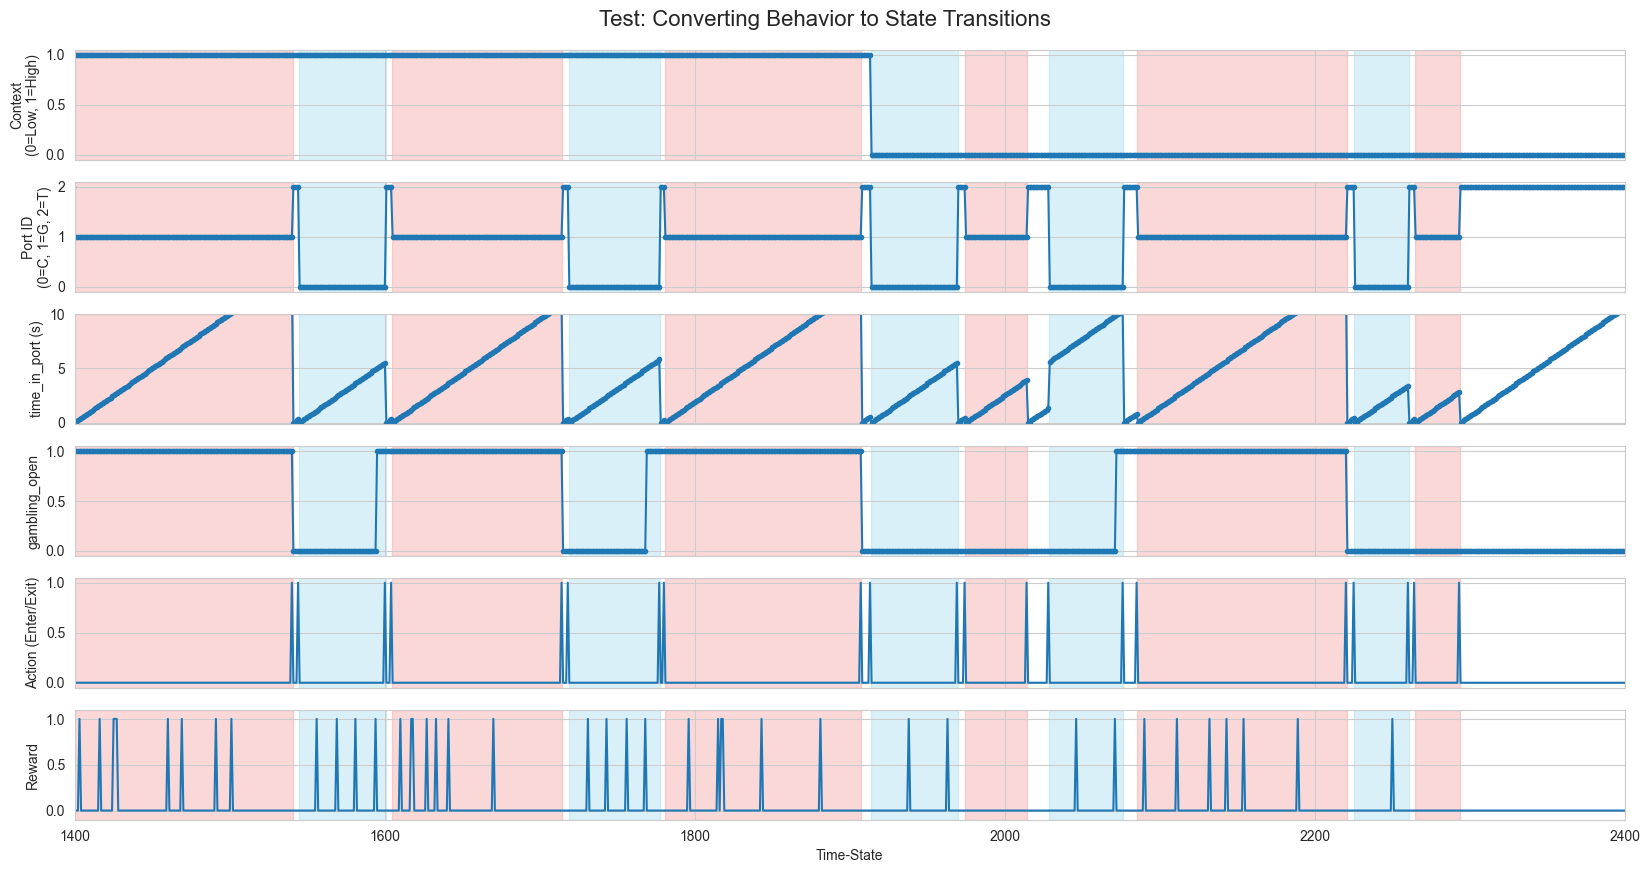

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(6, 1, figsize=(20, 10), sharex=True)

axes[0].plot(trace_context, '.-')
axes[0].set_ylabel("Context\n(0=Low, 1=High)")

axes[1].plot(trace_port, '.-')
axes[1].set_ylabel("Port ID\n(0=C, 1=G, 2=T)")
axes[2].plot(trace_NRI, '.-')
axes[2].set_ylabel("time_in_port (s)")
axes[2].set_ylim([-0.1, 10])
# axes[3].plot(trace_IRI, '.-')
# axes[3].set_ylabel("event_timer (s)")
# axes[3].set_ylim([-0.1, 10])
axes[3].plot(trace_gambling_available, '.-')
axes[3].set_ylabel("gambling_open")
axes[4].plot(trace_action, '-')
axes[4].set_ylabel("Action (Enter/Exit)")

axes[5].plot(trace_reward_next_state, '-')
axes[5].set_ylabel("Reward")
axes[5].set_ylim([-0.1, 1.1])


# axes[7].plot(trace_gambling_disabled, '.-')
# axes[7].set_ylabel("Gambling Disabled")
axes[-1].set_xlabel("Time-State")
spans_0 = list(find_spans(trace_port, 0))
spans_1 = list(find_spans(trace_port, 1))

for ax in axes:
    for start, end in spans_0:
        ax.axvspan(start, end, color='skyblue', alpha=0.3, zorder=0)
    for start, end in spans_1:
        ax.axvspan(start, end, color='lightcoral', alpha=0.3, zorder=0)
    # ax.set_xlim([250, 600])
    # ax.set_xlim([1800, 2500])
    ax.set_xlim([1400, 2400])

fig.suptitle("Test: Converting Behavior to State Transitions", fontsize=16, y=0.92)
plt.show()

# Test run the simulation for behavior data from one expert session

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mouse_playback_environment import MousePlaybackEnvironment
from mouse_playback_agent import MousePlaybackAgent
from data_loader import load_behavior_data, convert_behavior_data_to_state_transitions
from tqdm import tqdm

In [2]:
# --- Load and Convert Data ---
env_params_for_conversion = { # Params needed by the data loader
    "time_step_duration": 0.1,
    "session_duration_min": 18,
    "context_rewards_max": 4,
    "block_duration_min": 3
}
pi_events_df = load_behavior_data("SZ036", session_id=7) # Example
if pi_events_df is None:
    raise FileNotFoundError("Could not load behavior data.")

transitions = convert_behavior_data_to_state_transitions(pi_events_df, env_params_for_conversion)
if not transitions:
     raise ValueError("Data conversion resulted in empty transitions list.")

Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ036\processed_data\SZ036_2024-01-04T11_40_pi_events_processed.parquet
session: SZ036_2024-01-04T11_40
Test new conversion function 5th go...
Processing time steps...
Processed 10800 time steps.


In [3]:
# Simulation Setup
env_info_playback = { # Info needed by the playback environment
    'transitions': transitions,
    'time_step_duration': env_params_for_conversion['time_step_duration']
}
agent_info = {
    "discount": 0.95,
    "step_size": 0.1,
    "num_tilings": 16,
    "iht_size": 4096,
    # Pass necessary scaling info if agent needs it
    "gambling_max_time_s": 30.0,
    "context_rewards_max": 4
}

env = MousePlaybackEnvironment()
agent = MousePlaybackAgent()

env.env_init(env_info_playback)
agent.agent_init(agent_info)

Playback environment initialized with 10800 transitions.


In [4]:
# Run the playback simulation
all_trial_values = []
current_trial_data = []
was_in_gambling = False

GAMBLING_PORT_ID = 1.0
GAMBLING_ENABLED = 0.0
NUM_TRIALS_TO_PLOT = 50

observation = env.env_start()
agent.agent_start(observation)
terminal = False
step_count = 0
max_steps = len(transitions)

print("Running playback simulation using MousePlaybackEnvironment...")
while not terminal and step_count < max_steps:
    port_id, time_in_port, _, _, _, gambling_disabled = observation
    is_in_gambling = (port_id == GAMBLING_PORT_ID and gambling_disabled == GAMBLING_ENABLED)
    # Check if we just entered the gambling port
    if is_in_gambling and not was_in_gambling:
        current_trial_data = [] # Start a new trial trace

    # If we are in the port, record the time and value
    if is_in_gambling:
        # Get V(s_t) using the agent's weights *at time t*
        current_value = agent.get_value(observation)
        current_trial_data.append((time_in_port, current_value))

    # Check if we just *left* the gambling port
    if not is_in_gambling and was_in_gambling:
        if current_trial_data: # If we have data, save it
            all_trial_values.append(list(current_trial_data))
        if len(all_trial_values) >= NUM_TRIALS_TO_PLOT:
            print(f"Captured {len(all_trial_values)} trials. Stopping capture.")
            break # Stop the whole simulation

    was_in_gambling = is_in_gambling # Update state flag for next loop

    dummy_action = 0
    reward, next_observation, terminal = env.env_step(dummy_action)

    # Agent learns based on the outcome provided by the environment
    if terminal:
        agent.agent_end(reward)
    else:
        agent.agent_step(reward, next_observation)

    observation = next_observation # For the next loop iteration (though not used by agent.agent_step)
    step_count += 1

# Get results
if current_trial_data and len(all_trial_values) < NUM_TRIALS_TO_PLOT:
    all_trial_values.append(list(current_trial_data))

td_errors = np.array(agent.agent_message("get_td_errors"))
all_observations = np.array([t[0] for t in transitions]) # Retrieve observations from the transitions list
print(f"Playback finished after {step_count} steps.")

Running playback simulation using MousePlaybackEnvironment...
Playback finished after 10800 steps.


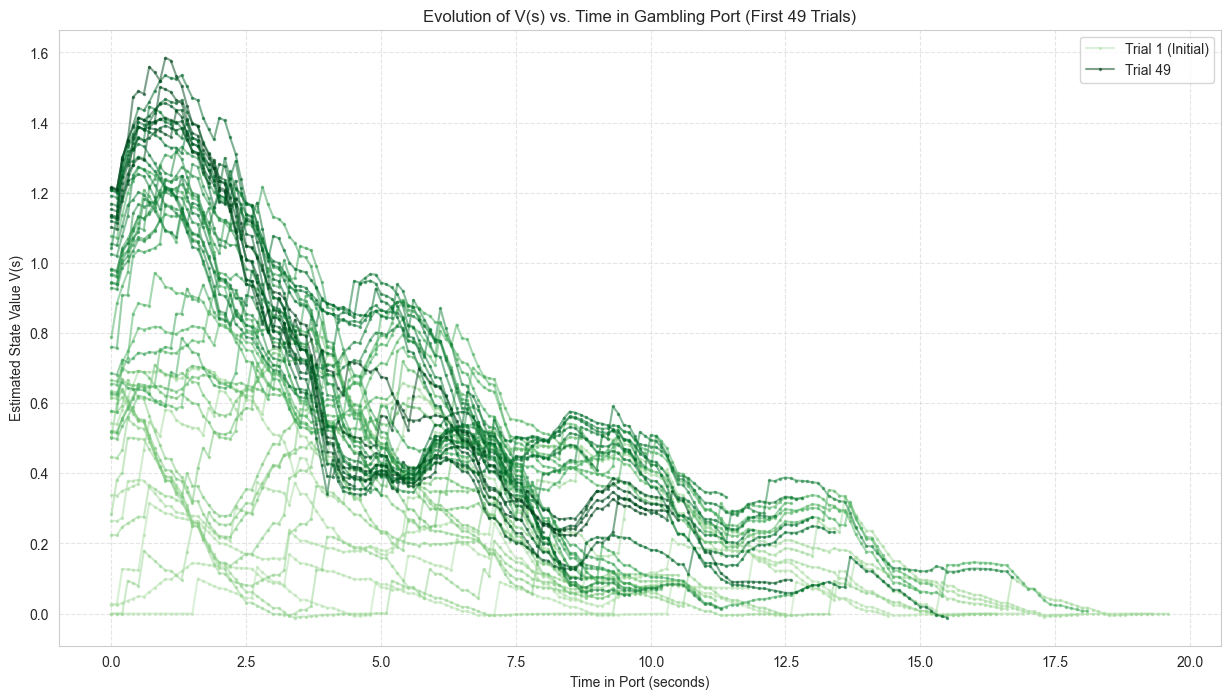

In [5]:
# Plot V(s) Evolution
plt.figure(figsize=(15, 8))

num_trials = len(all_trial_values)
if num_trials > 0:
    # Generate colors from light green (0.3) to dark green (1.0)
    colors = cm.Greens(np.linspace(0.3, 1, num_trials))

    for i, trial_data in enumerate(all_trial_values):
        # trial_data is a list of (time_in_port, value) tuples
        if not trial_data: # Skip empty trials
            continue

        times, values = zip(*trial_data)

        # Set label only for first and last trial for a cleaner legend
        label = None
        if i == 0:
            label = f'Trial 1 (Initial)'
        elif i == num_trials - 1:
            label = f'Trial {num_trials}'

        plt.plot(times, values, '.-', color=colors[i], alpha=0.5, markersize=3, label=label)

    plt.title(f'Evolution of V(s) vs. Time in Gambling Port (First {num_trials} Trials)')
    plt.xlabel('Time in Port (seconds)')
    plt.ylabel('Estimated State Value V(s)')

    # Check if any data was actually plotted before adding legend
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend(handles, labels)
    else:
        print("No data was plotted (all captured trials might be empty).")

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

else:
    print("No gambling trials were captured, cannot generate plot.")

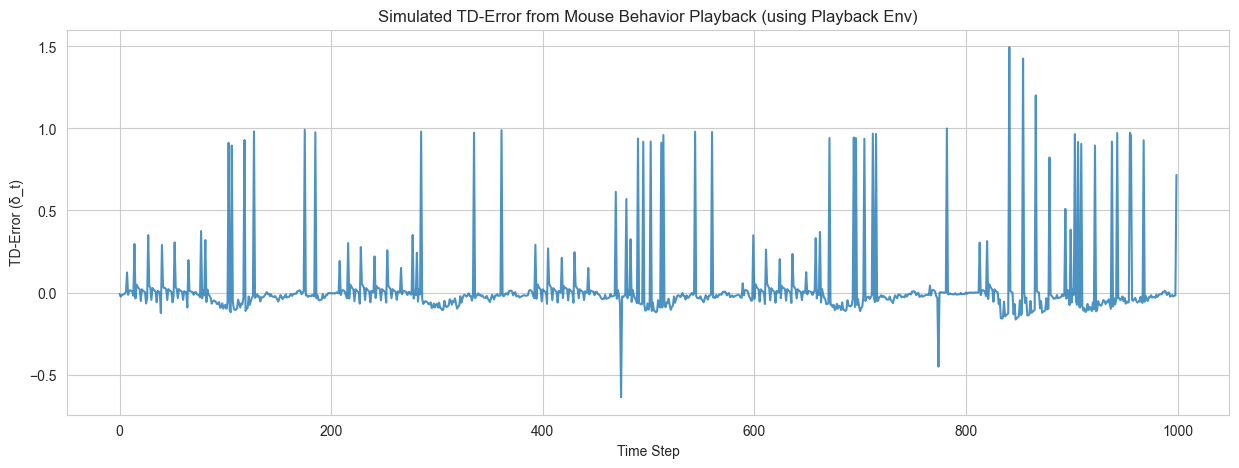

In [6]:
# Plot TD-error results
plt.figure(figsize=(15, 5))
plt.plot(td_errors[-1000:], alpha=0.8)
plt.title("Simulated TD-Error from Mouse Behavior Playback (using Playback Env)")
plt.xlabel("Time Step")
plt.ylabel("TD-Error (δ_t)")
plt.show()

In [7]:
# test
all_rewards = np.array([t[2] for t in transitions])

# --- Find indices where a reward was delivered ---
reward_indices = np.where(all_rewards == 1.0)[0]

# --- Verification Step: Check a few instances ---
print("\n--- Verification: Checking TD-Error for steps after rewards ---")
gambling_port_id = 1
verified_indices_found = [] # Keep track of indices we expect in the plot
check_count = 0
max_checks = 5 # How many instances to print

for reward_idx in reward_indices:
    if reward_idx + 1 < len(td_errors):

        # State entered *after* the reward (this is obs_t_plus_1 from the reward transition)
        state_after_reward = transitions[reward_idx][3] # equivalent to all_observations[reward_idx + 1]

        # Check if this state is in the gambling port
        if state_after_reward[0] == gambling_port_id:

            # The TD-error calculated *during* the step STARTING from state_after_reward
            td_error_after_reward = td_errors[reward_idx]
            time_in_port_at_error_calc = state_after_reward[1] # Time in port when error was calculated

            # Print details for verification
            if check_count < max_checks:
                print(f"\nInstance {check_count + 1}:")
                print(f"  Reward occurred at step index: {reward_idx}")
                print(f"  State entered after reward (obs_t for next step): {np.round(state_after_reward, 2)}")
                print(f"  TD-Error calculated at NEXT step (index {reward_idx + 1}): {td_error_after_reward:.4f}")
                print(f"  Time in Port at TD-Error calculation: {time_in_port_at_error_calc:.2f}s")

            verified_indices_found.append(reward_idx + 1) # Store the index of the TD-error step
            check_count += 1

# --- Compare verified indices with the ones selected for plotting ---
print(f"\nTotal reward indices found: {len(reward_indices)}")
print(f"Total indices meeting criteria (in gambling port, step after reward): {len(verified_indices_found)}")


--- Verification: Checking TD-Error for steps after rewards ---

Instance 1:
  Reward occurred at step index: 151
  State entered after reward (obs_t for next step): [1.  1.6 0.  0.  4.  0. ]
  TD-Error calculated at NEXT step (index 152): 1.0000
  Time in Port at TD-Error calculation: 1.60s

Instance 2:
  Reward occurred at step index: 162
  State entered after reward (obs_t for next step): [1.  2.7 0.  0.  4.  0. ]
  TD-Error calculated at NEXT step (index 163): 0.9923
  Time in Port at TD-Error calculation: 2.70s

Instance 3:
  Reward occurred at step index: 184
  State entered after reward (obs_t for next step): [1.  4.9 0.  0.  4.  0. ]
  TD-Error calculated at NEXT step (index 185): 1.0009
  Time in Port at TD-Error calculation: 4.90s

Instance 4:
  Reward occurred at step index: 207
  State entered after reward (obs_t for next step): [1.  7.2 0.  0.  4.  0. ]
  TD-Error calculated at NEXT step (index 208): 1.0008
  Time in Port at TD-Error calculation: 7.20s

Instance 5:
  Rewa

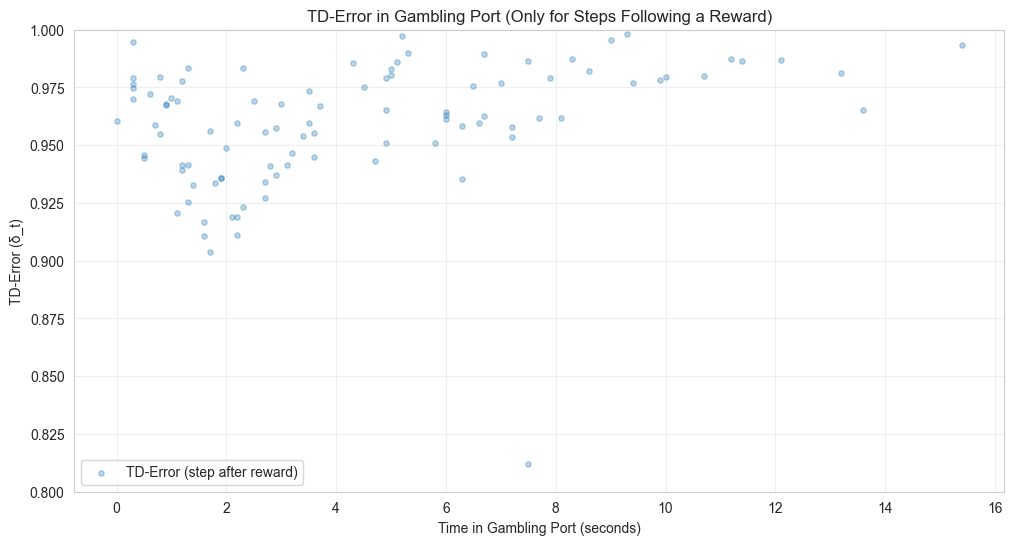

In [8]:
# plot td-error vs. time_in_port in the gambling port
all_rewards = np.array([t[2] for t in transitions])

indices_to_plot = []
gambling_port_id = 1

# Start loop from 1 (so we can check i-1)
for i in range(0, len(transitions)):

    # Condition 1: A reward was delivered in the previous step (i-1)
    reward_in_prev_step = (all_rewards[i] == 1.0)

    # Condition 2: The current state (i) is in the gambling port
    in_gambling_port = (all_observations[i, 0] == gambling_port_id)

    if reward_in_prev_step and in_gambling_port:
        indices_to_plot.append(i)

# Filter data using the selected indices
if indices_to_plot:
    td_errors_filtered = td_errors[indices_to_plot]
    observations_filtered = all_observations[indices_to_plot]

    # Extract the 'time_in_port' (index 1) from the filtered observations
    time_in_port_filtered = observations_filtered[:, 1]

    # --- Create the Scatter Plot ---
    plt.figure(figsize=(12, 6))
    plt.scatter(time_in_port_filtered[100:200], td_errors_filtered[100:200], alpha=0.3, s=15,
                label="TD-Error (step after reward)")

    plt.ylim([0.8, 1])
    plt.title("TD-Error in Gambling Port (Only for Steps Following a Reward)")
    plt.xlabel("Time in Gambling Port (seconds)")
    plt.ylabel("TD-Error (δ_t)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

else:
    print("No data points matched the criteria (in gambling port and step after a reward).")

# Pre-train agent with pooled data from real behavior sessions and analyze TD-error for target sessions

## 1. Pretraining

In [45]:
import pandas as pd
import os
import config
import glob
from data_loader import load_behavior_data, convert_behavior_data_to_state_transitions

def pool_animal_transitions(animal_str, env_params):
    """
    Finds all processed .parquet files for an animal, loads them,
    converts them to transitions, and pools them together.
    """
    print(f"--- Pooling data for animal: {animal_str} ---")
    pooled_transitions = []

    # 1. Find the directory with the processed files
    animal_dir = os.path.normpath(os.path.join(config.MAIN_DATA_ROOT, animal_str))
    processed_dir = os.path.join(animal_dir, config.PRETRAINING_PROCESSED_DATA_SUBDIR)

    # 2. Create a "pattern" to find all .parquet files
    file_pattern = os.path.join(processed_dir, "*_pi_events_proccessed.parquet")

    # 3. Use glob to get a list of all files matching the pattern
    session_files = glob.glob(file_pattern)

    if not session_files:
        print(f"⚠️ No .parquet files found for {animal_str} in {processed_dir}")
        return []

    print(f"Found {len(session_files)} sessions to pool.")

    # 4. Loop through the list of files
    for file_path in session_files:
        try:
            df = pd.read_parquet(file_path)

            if df.empty:
                print(f"Skipping empty session file: {os.path.basename(file_path)}")
                continue

            session_transitions = convert_behavior_data_to_state_transitions(df, env_params)

            pooled_transitions.extend(session_transitions)

        except Exception as e:
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"⚠️ ERROR: Failed to process file: {os.path.basename(file_path)}")
            print(f"   Error details: {e}")
            print(f"   Skipping this file.")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            continue

    print(f"--- Finished pooling for {animal_str} ---")
    print(f"Total transitions pooled: {len(pooled_transitions)}")

    return pooled_transitions

In [46]:
# Pool the data first
env_params = { # Params needed by the data loader
    "time_step_duration": 0.1,
    "session_duration_min": 18,
    "context_rewards_max": 4,
    "block_duration_min": 3
}

animal_to_pool = "SZ037"
pooled_transitions = pool_animal_transitions(animal_to_pool, env_params)


--- Pooling data for animal: SZ037 ---
Found 65 sessions to pool.
Processing time steps...
Processed 10732 time steps.
Processing time steps...
Processed 10746 time steps.
Processing time steps...
Processed 10780 time steps.
Processing time steps...
Processed 10790 time steps.
Processing time steps...
Processed 10796 time steps.
Processing time steps...
Processed 10796 time steps.
Processing time steps...
Processed 10788 time steps.
Processing time steps...
Processed 10794 time steps.
Processing time steps...
Processed 10789 time steps.
Processing time steps...
Processed 10788 time steps.
Processing time steps...
Processed 10781 time steps.
Processing time steps...
Processed 10797 time steps.
Processing time steps...
Processed 10789 time steps.
Processing time steps...
Processed 10798 time steps.
Processing time steps...
Processed 10758 time steps.
Processing time steps...
Processed 10789 time steps.
Processing time steps...
Processed 10749 time steps.
Processing time steps...
Processe

In [47]:
# Save pooled transitions
import pickle
filename = f'pooled_transitions_{animal_to_pool}.pkl'
print(f"Saving list to {filename}...")
try:
    # 'wb' mode means 'write binary'
    with open(filename, 'wb') as file:
        # pickle.dump() serializes the object and writes to the file
        pickle.dump(pooled_transitions, file)
    print("List saved successfully.")

except IOError as e:
    print(f"Error saving file: {e}")
except pickle.PicklingError as e:
    print(f"Error pickling object: {e}")

Saving list to pooled_transitions_SZ037.pkl...
List saved successfully.


In [113]:
import numpy as np
import itertools

# --- 1. Define the dimensions of interest ---
times_in_port = np.arange(0.0, 25.0, 0.1) # [0.5, 1.5, ..., 14.5]
times_in_port_context = np.arange(0.0, 12.0, 0.1)
contexts = [0.0, 1.0]                     # [Low, High]

probe_states_dict = {}

# --- 2. Generate GAMBLING Port (port=0) probe states ---
# State vector: [port, time_in_port, event_timer, context, rewards_in_context, gambling_disabled]

# Use itertools.product to get all combinations
gambling_combinations = itertools.product(times_in_port, contexts)

for tip, context in gambling_combinations:
    # In Gambling port, rewards_in_context is 4
    # and event_timer matches time_in_port
    state_vector = [
        1.0,          # port = 1 (Gambling)
        round(tip, 3), # time_in_port
        0.0, # event_timer (collapsed to 1d because we don't care about it for now)
        context,      # context (0=Low, 1=High)
        0.0,          # rewards_in_context (collapsed to 1d)
        0.0
    ]

    # Create a descriptive name for plotting
    context_name = "Low" if context == 0.0 else "High"
    state_name = f"V(Gamb_{context_name}_tip={tip}s)"

    probe_states_dict[state_name] = state_vector

# --- 3. Generate CONTEXT Port (port=0) probe states ---
# Use itertools.product for all combinations
context_combinations = itertools.product(times_in_port_context, contexts)

for tip, context in context_combinations:
    # In Context port, event_timer matches time_in_port
    state_vector = [
        0.0,          # port = 1 (Context)
        round(tip, 3), # time_in_port
        0.0, # event_timer (collapsed to 1d)
        context,      # context (0=Low, 1=High)
        0.0,      # rewards_in_context (collapsed to 1d)
        1.0
    ]

    # Create a descriptive name for plotting
    context_name = "Low" if context == 0.0 else "High"
    state_name = f"V(Cont_{context_name}_tip={tip}s)"

    probe_states_dict[state_name] = state_vector

# --- 4. Check the results ---
print(f"Generated a total of {len(probe_states_dict)} probe states.")
print("\n--- Example Gambling States ---")
g_keys = [k for k in probe_states_dict if k.startswith("V(Gamb")][::50] # Show a few
for k in g_keys:
    print(f"{k}: {probe_states_dict[k]}")

print("\n--- Example Context States ---")
c_keys = [k for k in probe_states_dict if k.startswith("V(Cont")][::250] # Show a few
for k in c_keys:
    print(f"{k}: {probe_states_dict[k]}")

Generated a total of 740 probe states.

--- Example Gambling States ---
V(Gamb_Low_tip=0.0s): [1.0, np.float64(0.0), 0.0, 0.0, 0.0, 0.0]
V(Gamb_Low_tip=2.5s): [1.0, np.float64(2.5), 0.0, 0.0, 0.0, 0.0]
V(Gamb_Low_tip=5.0s): [1.0, np.float64(5.0), 0.0, 0.0, 0.0, 0.0]
V(Gamb_Low_tip=7.5s): [1.0, np.float64(7.5), 0.0, 0.0, 0.0, 0.0]
V(Gamb_Low_tip=10.0s): [1.0, np.float64(10.0), 0.0, 0.0, 0.0, 0.0]
V(Gamb_Low_tip=12.5s): [1.0, np.float64(12.5), 0.0, 0.0, 0.0, 0.0]
V(Gamb_Low_tip=15.0s): [1.0, np.float64(15.0), 0.0, 0.0, 0.0, 0.0]
V(Gamb_Low_tip=17.5s): [1.0, np.float64(17.5), 0.0, 0.0, 0.0, 0.0]
V(Gamb_Low_tip=20.0s): [1.0, np.float64(20.0), 0.0, 0.0, 0.0, 0.0]
V(Gamb_Low_tip=22.5s): [1.0, np.float64(22.5), 0.0, 0.0, 0.0, 0.0]

--- Example Context States ---
V(Cont_Low_tip=0.0s): [0.0, np.float64(0.0), 0.0, 0.0, 0.0, 1.0]


### Run all the episodes for once

In [112]:
# Configuration
ANIMAL_ID = "SZ037"
POOLED_DATA_FILE = f"pooled_transitions_{ANIMAL_ID}.pkl"
USE_REDUNDANT_FEATURES = False

In [128]:
# Load transitions first
import pickle
from mouse_playback_environment import MousePlaybackEnvironment # NEW
from mouse_playback_agent import MousePlaybackAgent

print(f"Loading pooled transitions from {POOLED_DATA_FILE}...")
try:
    with open(POOLED_DATA_FILE, 'rb') as f:
        pooled_transitions = pickle.load(f)
    print(f"Loaded {len(pooled_transitions)} transitions.")
except FileNotFoundError:
    print(f"Error: {POOLED_DATA_FILE} not found.")
    pooled_transitions = None
except Exception as e:
    print(f"An error occurred loading the pickle file: {e}")
    pooled_transitions = None

# Set up the environment and the agent
# Define the full 6-feature configurations
full_scales = [
    -1,  # 0: port
    1 / 30.0, # 1: time_in_port
    1 / 10.0,  # 2: event_timer
    -1,  # 3: context
    -1,  # 4: rewards_in_context
    -1   # 5: gambling_disabled
]

# Create the final config
if USE_REDUNDANT_FEATURES:
    scales_to_use = full_scales
    print("Agent will use 6 features (including event_timer).")
else:
    # To "remove" a feature, we set its scale to 0.0
    # and its tiling dimension to 1 (so it's not subdivided).
    scales_to_use = [
        -1,  # 0: port
        1 / 2.0, # 1: time_in_port
        0.0,      # 2: event_timer (SCALE SET TO 0)
        -1,  # 3: context
        0.0,  # 4: rewards_in_context
        -1   # 5: gambling_disabled
    ]
    print("Agent will use 4 features (event_timer and context_rewards scales are 0).")

if pooled_transitions:
    print("Initializing agent and environment...")

    env = MousePlaybackEnvironment()
    env_params_for_playback = {"transitions": pooled_transitions, "time_step_duration": 0.1}
    env.env_init(env_params_for_playback)

    agent = MousePlaybackAgent()
    agent_params = {
        "discount": 0.95, # Or chosen value
        "step_size": 0.025, # Start with a smaller step size for stability over large datasets
        "num_tilings": 16,
        "iht_size": 4096,
        "gambling_max_time_s": 30.0, # Match data_loader params if used
        "context_rewards_max": 4,  # Match data_loader params if used
        "scales": scales_to_use
    } # agent parameters
    agent.agent_init(agent_params)


Loading pooled transitions from pooled_transitions_SZ037.pkl...
Loaded 700965 transitions.
Agent will use 4 features (event_timer and context_rewards scales are 0).
Initializing agent and environment...
Playback environment initialized with 700965 transitions.


In [115]:
# Only run 1 epoch
import pandas as pd
import numpy as np

OUTPUT_WITHIN_EPISODE_STATE_EVO_FILE = "value_evolution_epoch0_episode_early_mid_late.parquet"
EPISODES_TO_LOG = [0, 1, 2, 30, 31, 32, 61, 62, 63]
OUTPUT_ACROSS_EPISODE_STATE_EVO_FILE = "last_trial_value_evolution_by_episode.parquet"

print(f"Start training and logging for Epoch 0, Episodes {EPISODES_TO_LOG}...")
print(f"Also capturing the values and weight changes across episodes...")

GAMBLING_PORT_ID = 1
GAMBLING_ENABLED = 0.0

# initialize the lists to store values
value_evo_within_episodes = []
value_evo_across_episodes = []
current_trial_data = []
current_trial_context = None

# State trackers
episode_index = 0
trial_in_episode = -1
step_in_trial = 0
was_in_gambling = False

epoch = 0

obs_t = env.env_start()
agent.agent_start(obs_t)
prev_w = np.zeros_like(agent.iht_size)

is_terminal = False

while True:
    current_port, time_in_port, _, context, _, gambling_disabled = obs_t
    is_in_gambling = (current_port == GAMBLING_PORT_ID and gambling_disabled == GAMBLING_ENABLED)

    # Check if we just entered the gambling port
    if is_in_gambling and not was_in_gambling:
        trial_in_episode += 1
        step_in_trial = 0
        current_trial_data = []
        current_trial_context = context

    # If we are in the port, record the time and value
    if is_in_gambling:
        # Get V(s_t) using the agent's weights *at time t*
        current_value = agent.get_value(obs_t)
        log_entry_base = {
            "step_in_trial": step_in_trial,
            "time_in_port": time_in_port,
            "state_value": current_value,
            "reward_t_plus_1": None,
        }
        current_trial_data.append(log_entry_base)

        if episode_index in EPISODES_TO_LOG:
            log_entry_full = {
                "epoch": epoch,
                "episode_index": episode_index,
                "trial_in_episode": trial_in_episode,
                **log_entry_base
            }
            value_evo_within_episodes.append(log_entry_full)

        step_in_trial += 1

    was_in_gambling = is_in_gambling # Update state flag for next loop

    reward_t_plus_1, next_observation, is_terminal = env.env_step(None)

    if is_in_gambling:
        current_trial_data[-1]["reward_t_plus_1"] = reward_t_plus_1
        if episode_index in EPISODES_TO_LOG:
            value_evo_within_episodes[-1]["reward_t_plus_1"] = reward_t_plus_1

    agent.agent_step(reward_t_plus_1, next_observation)

    obs_t = next_observation # For the next loop iteration (though not used by agent.agent_step)

    if is_terminal:
        current_w = agent.w
        current_weight_norm = np.linalg.norm(agent.w)
        weight_diff_norm = np.linalg.norm(current_w - prev_w)
        probe_values_this_epoch = {}
        for state_name, state_vector in probe_states_dict.items():
            probe_values_this_epoch[state_name] = agent.get_value(state_vector)
            # current_w = agent.get_weights(state_vector)
            # current_weight_norm = np.linalg.norm(current_w)
            # weight_diff_norm = np.linalg.norm(current_w - prev_w)
        value_evo_across_episodes.append({
            "epoch": epoch,
            "episode_index": episode_index,
            "trial_in_episode": trial_in_episode,
            "context": current_trial_context,
            "value_evolution": current_trial_data,
            "probe_values": probe_values_this_epoch,
            "weight_norm_l2": current_weight_norm,
            "weight_diff_norm_l2": weight_diff_norm
        })
        prev_w = current_w.copy()
        # Check if we're at the very end of the entire pooled dataset
        if env.current_step_index >= len(env.transitions):
            print(f"Completed Epoch {epoch}.")
            break # Exit the 'while True' loop when we are at the end of the whole dataset
        else:
            # This was just the end of an episode, not the whole epoch
            print(f"End of Episode {episode_index}.")
            episode_index += 1

            # Reset trial counters for new episode
            trial_in_episode = -1
            was_in_gambling = False
            current_trial_data = []
            current_trial_context = None
            # Start the new episode (agent.agent_start sets last_state_tiles)
            # obs_t is already obs_t_plus_1 from the last step, which is the
            # first state of the new episode.
            agent.agent_start(obs_t)

print("Training loop finished")

if value_evo_across_episodes:
    print("Saving logged data to DataFrame...")
    value_evo_last_trial_df = pd.DataFrame(value_evo_across_episodes)

    print(f"Saving DataFrame to {OUTPUT_ACROSS_EPISODE_STATE_EVO_FILE} using Parquet...")
    value_evo_last_trial_df.to_parquet(OUTPUT_ACROSS_EPISODE_STATE_EVO_FILE, index=False, compression='gzip')

    print("\nData logging complete. Here's a sample of the data:")
    print(value_evo_last_trial_df.head())
    print(f"\nData saved for {len(value_evo_last_trial_df)} episodes.")
else:
    print(f"No data was logged. Did the agent encounter any gambling port (1) trials?")

if value_evo_within_episodes:
    print("Saving logged data to DataFrame...")
    value_evo_selected_episodes_df = pd.DataFrame(value_evo_within_episodes)

    print(f"Saving DataFrame to {OUTPUT_WITHIN_EPISODE_STATE_EVO_FILE}...")
    value_evo_selected_episodes_df.to_parquet(OUTPUT_WITHIN_EPISODE_STATE_EVO_FILE, index=False)

    print("\nData logging complete. Here's a sample of the data:")
    print(value_evo_selected_episodes_df.head())
    print(f"\nData saved for episodes: {value_evo_selected_episodes_df['episode_index'].unique()}")
else:
    print(f"No data was logged. Did episodes {EPISODES_TO_LOG} have any gambling port (1) trials?")

Start training and logging for Epoch 0, Episodes [0, 1, 2, 30, 31, 32, 61, 62, 63]...
Also capturing the values and weight changes across episodes...
End of Episode 0.
End of Episode 1.
End of Episode 2.
End of Episode 3.
End of Episode 4.
End of Episode 5.
End of Episode 6.
End of Episode 7.
End of Episode 8.
End of Episode 9.
End of Episode 10.
End of Episode 11.
End of Episode 12.
End of Episode 13.
End of Episode 14.
End of Episode 15.
End of Episode 16.
End of Episode 17.
End of Episode 18.
End of Episode 19.
End of Episode 20.
End of Episode 21.
End of Episode 22.
End of Episode 23.
End of Episode 24.
End of Episode 25.
End of Episode 26.
End of Episode 27.
End of Episode 28.
End of Episode 29.
End of Episode 30.
End of Episode 31.
End of Episode 32.
End of Episode 33.
End of Episode 34.
End of Episode 35.
End of Episode 36.
End of Episode 37.
End of Episode 38.
End of Episode 39.
End of Episode 40.
End of Episode 41.
End of Episode 42.
End of Episode 43.
End of Episode 44.
End o

In [116]:
# Save the agent weight for subsequent use
expert_weight = agent.w.copy()
np.save(f"expert_weights_single_epoch_{ANIMAL_ID}.npy", expert_weight)
print("Saved expert weights.")

Saved expert weights.


#### Plot State Value Evolution Trial by Trial in Selected Episodes

In [117]:
# plot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os

def plot_episode_evolution(df, episode_index, cmap_name='Greens'):
    """
    Plots the state value evolution for all trials in a single episode.
    Color-codes trials from light green (start) to dark green (end).

    Args:
        df (pd.DataFrame): The DataFrame containing the logged data.
        episode_index (int): The specific episode to plot.
        cmap_name (str): The name of the matplotlib colormap to use.
    """
    print(f"--- Plotting evolution for Episode {episode_index} ---")

    # Filter the DataFrame for the specific episode
    episode_df = df[df['episode_index'] == episode_index].copy()

    if episode_df.empty:
        print(f"Warning: No data found for episode {episode_index}. Skipping plot.")
        return

    # Find all unique trials in this episode
    all_trials = episode_df['trial_in_episode'].unique()
    all_trials.sort()
    num_trials = len(all_trials)

    if num_trials == 0:
        print(f"Warning: No trials found for episode {episode_index}. Skipping plot.")
        return

    print(f"Found {num_trials} trials for this episode.")

    # --- Set up the Colormap ---
    if num_trials == 1:
        colors_list = ['blue']
    elif num_trials == 2:
        colors_list = ['blue', 'red']
    else:
        colors_list = ['blue']
        cmap_greens = plt.get_cmap('Greens')
        green_colors = cmap_greens(np.linspace(0.3, 1.0, num_trials - 2))
        colors_list.extend(green_colors)
        colors_list.append('red')

    cmap = mcolors.ListedColormap(colors_list)

    # Create a normalizer that maps trial numbers (e.g., 0 to 50)
    # to the color map range (0.0 to 1.0)
    # We use vmin=0 to start from the beginning of the colormap
    norm = mcolors.Normalize(vmin=all_trials.min(), vmax=all_trials.max())

    # Create the mappable object that we can use for the color bar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) # We need to set an empty array for it to work

    # --- Create the Plot ---
    fig, ax = plt.subplots(figsize=(12, 7))

    for trial in all_trials:
        trial_df = episode_df[episode_df['trial_in_episode'] == trial]

        if not trial_df.empty:
            # Get the correct color for this trial from the colormap
            trial_color = cmap(norm(trial))

            # Plot time_in_port (x) vs. state_value (y)
            ax.plot(
                trial_df['time_in_port'],
                trial_df['state_value'],
                color=trial_color,
                alpha=0.7,
                linewidth=1.5
            )

    # --- Add Labels and Title ---
    ax.set_xlabel("Time in Port (s)")
    ax.set_ylabel("Estimated State Value V(s)")
    ax.set_title(f"State Value Evolution at Gambling Port\nEpisode {episode_index} (Epoch 0)")
    ax.grid(True, linestyle='--', alpha=0.5)

    # --- Add Color Bar ---
    # Add the color bar to the plot, using the ScalarMappable
    cbar = fig.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label("Trial in Episode")

Loading data from value_evolution_epoch0_episode_early_mid_late.parquet...
Data loaded successfully.
--- Plotting evolution for Episode 0 ---
Found 20 trials for this episode.
--- Plotting evolution for Episode 1 ---
Found 53 trials for this episode.
--- Plotting evolution for Episode 2 ---
Found 57 trials for this episode.
--- Plotting evolution for Episode 30 ---
Found 49 trials for this episode.
--- Plotting evolution for Episode 31 ---
Found 56 trials for this episode.
--- Plotting evolution for Episode 32 ---
Found 53 trials for this episode.
--- Plotting evolution for Episode 61 ---
Found 59 trials for this episode.
--- Plotting evolution for Episode 62 ---
Found 62 trials for this episode.
--- Plotting evolution for Episode 63 ---
Found 56 trials for this episode.

All plotting complete.


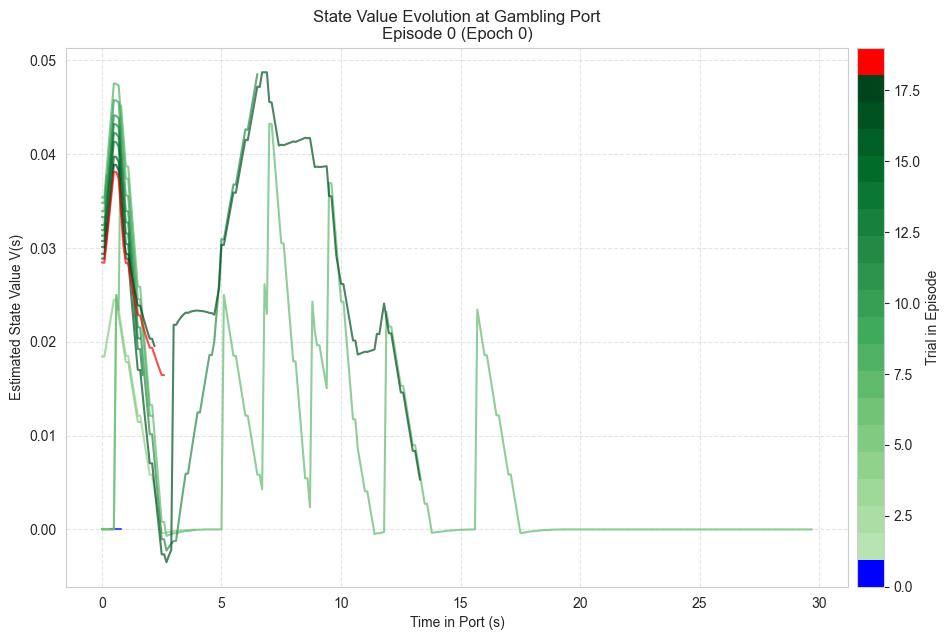

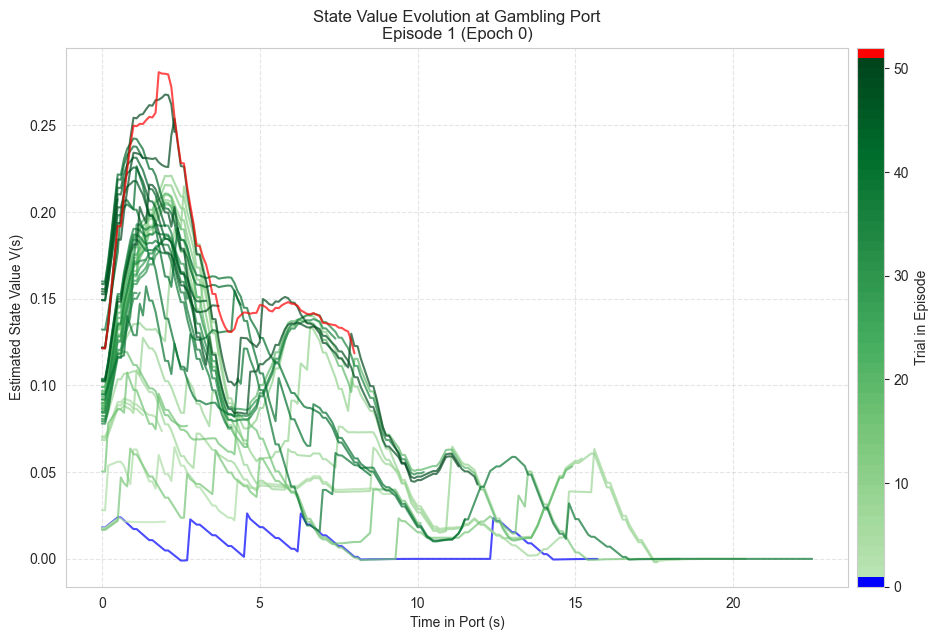

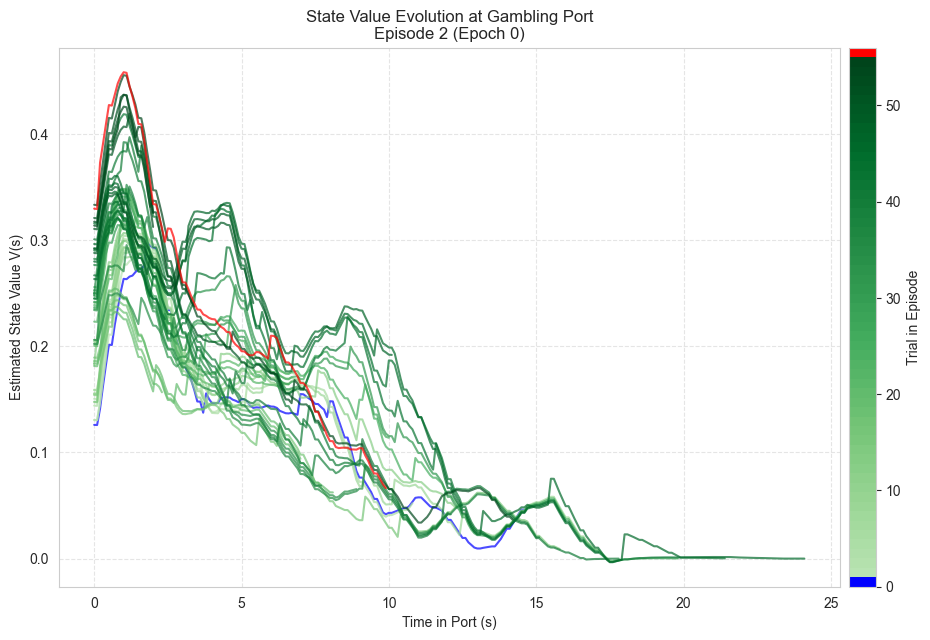

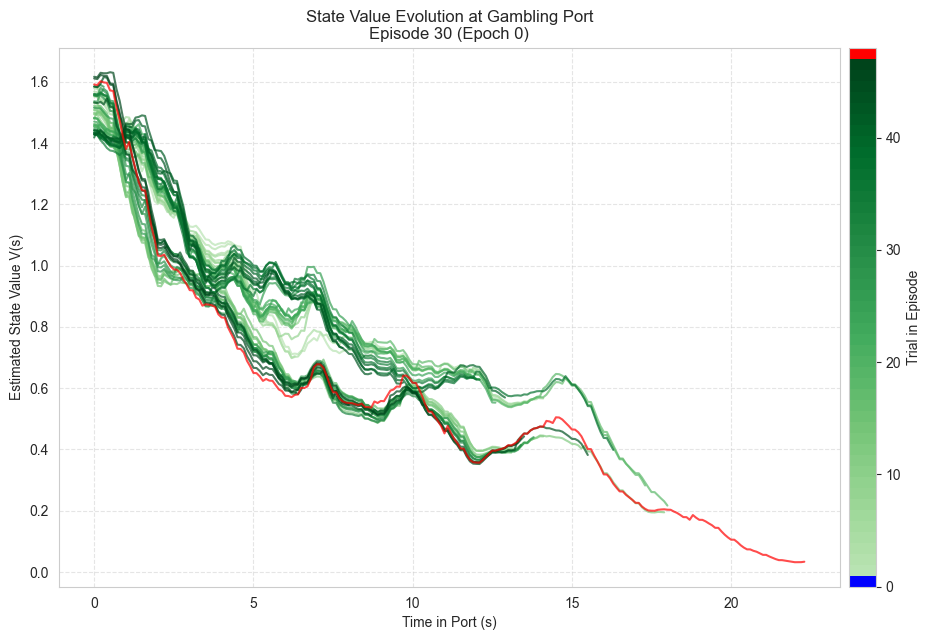

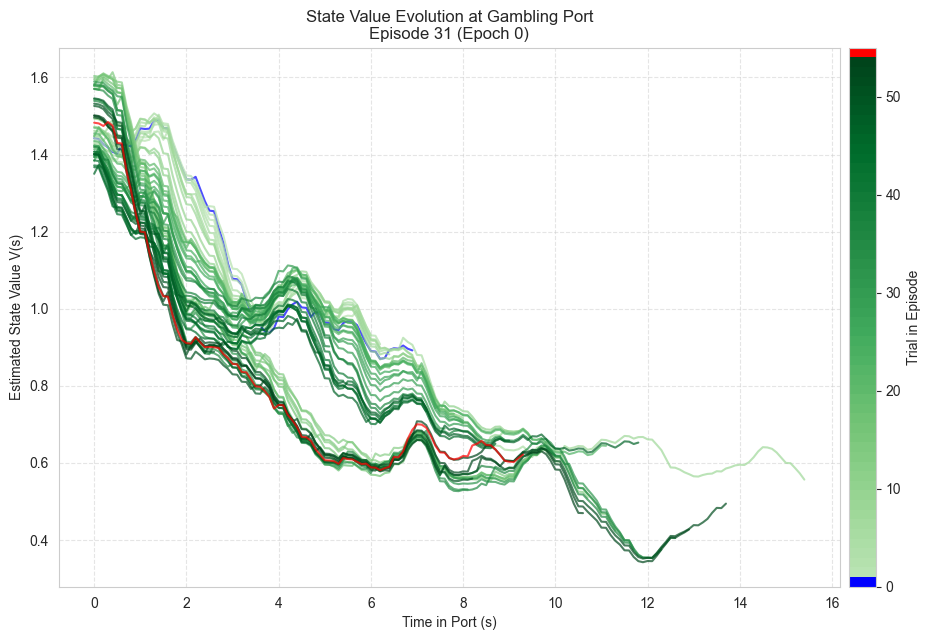

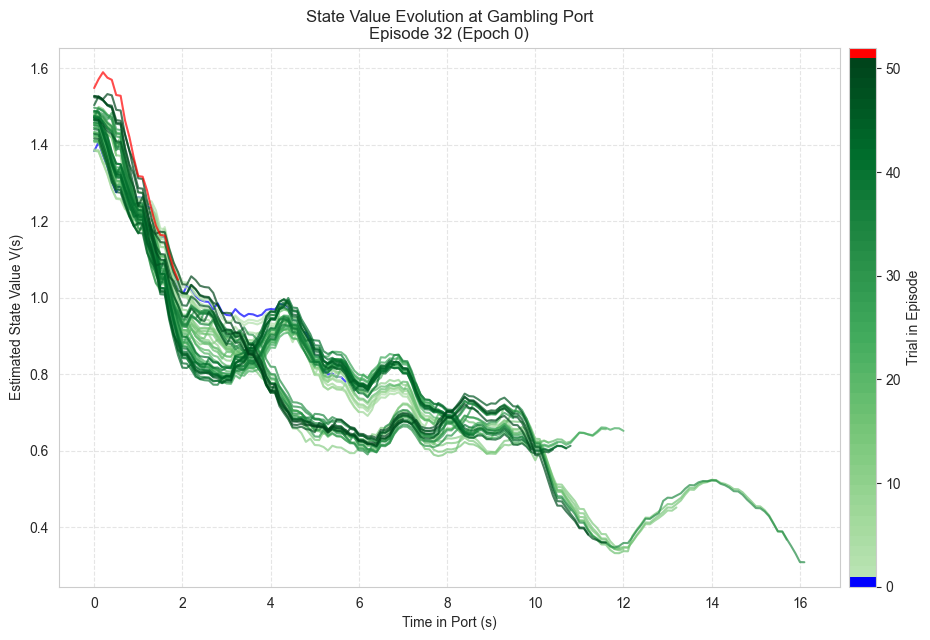

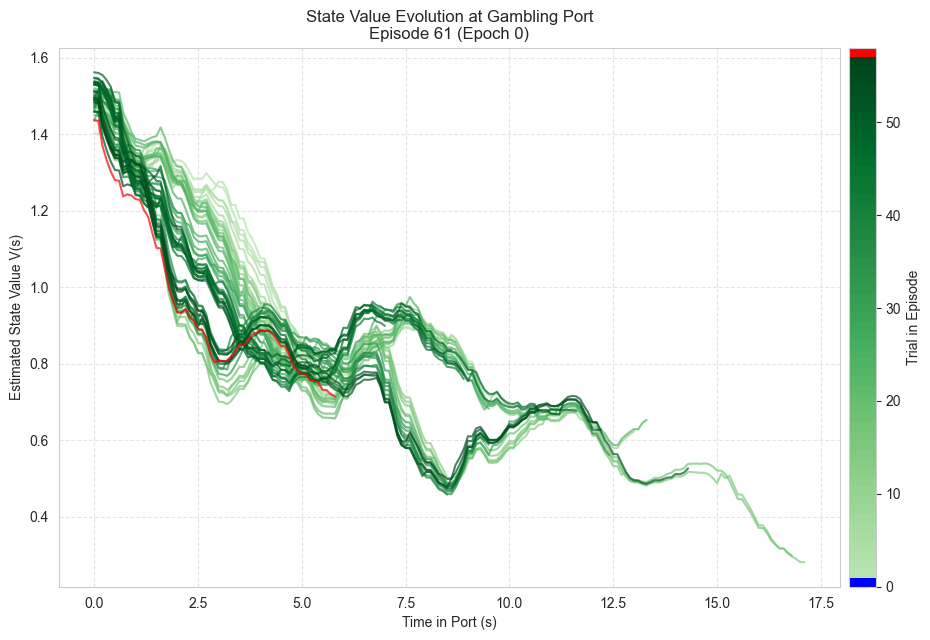

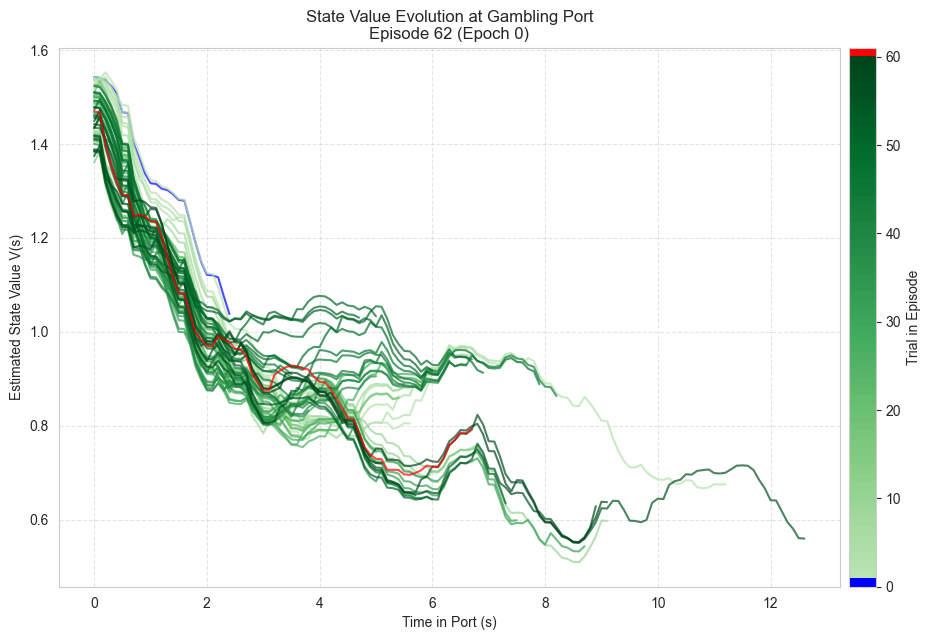

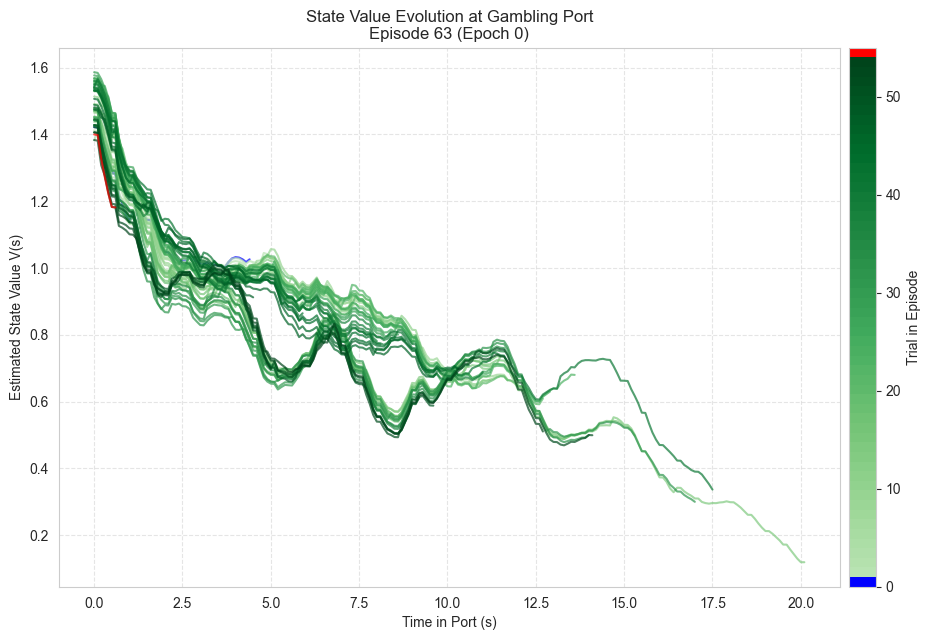

In [118]:
INPUT_FILE = "value_evolution_epoch0_episode_early_mid_late.parquet"
CMAP_NAME = 'Greens' # Colormap
print(f"Loading data from {INPUT_FILE}...")
df = pd.read_parquet(INPUT_FILE)
print("Data loaded successfully.")

for episode in EPISODES_TO_LOG:
    plot_episode_evolution(df, episode_index=episode, cmap_name=CMAP_NAME)

print("\nAll plotting complete.")

#### Plot State Value Evolution Episode by Episode

Loading data from last_trial_value_evolution_by_episode.parquet...
Unpacking 'value_evolution' data...
Data unpacked successfully. Now plotting...
Plotting complete.


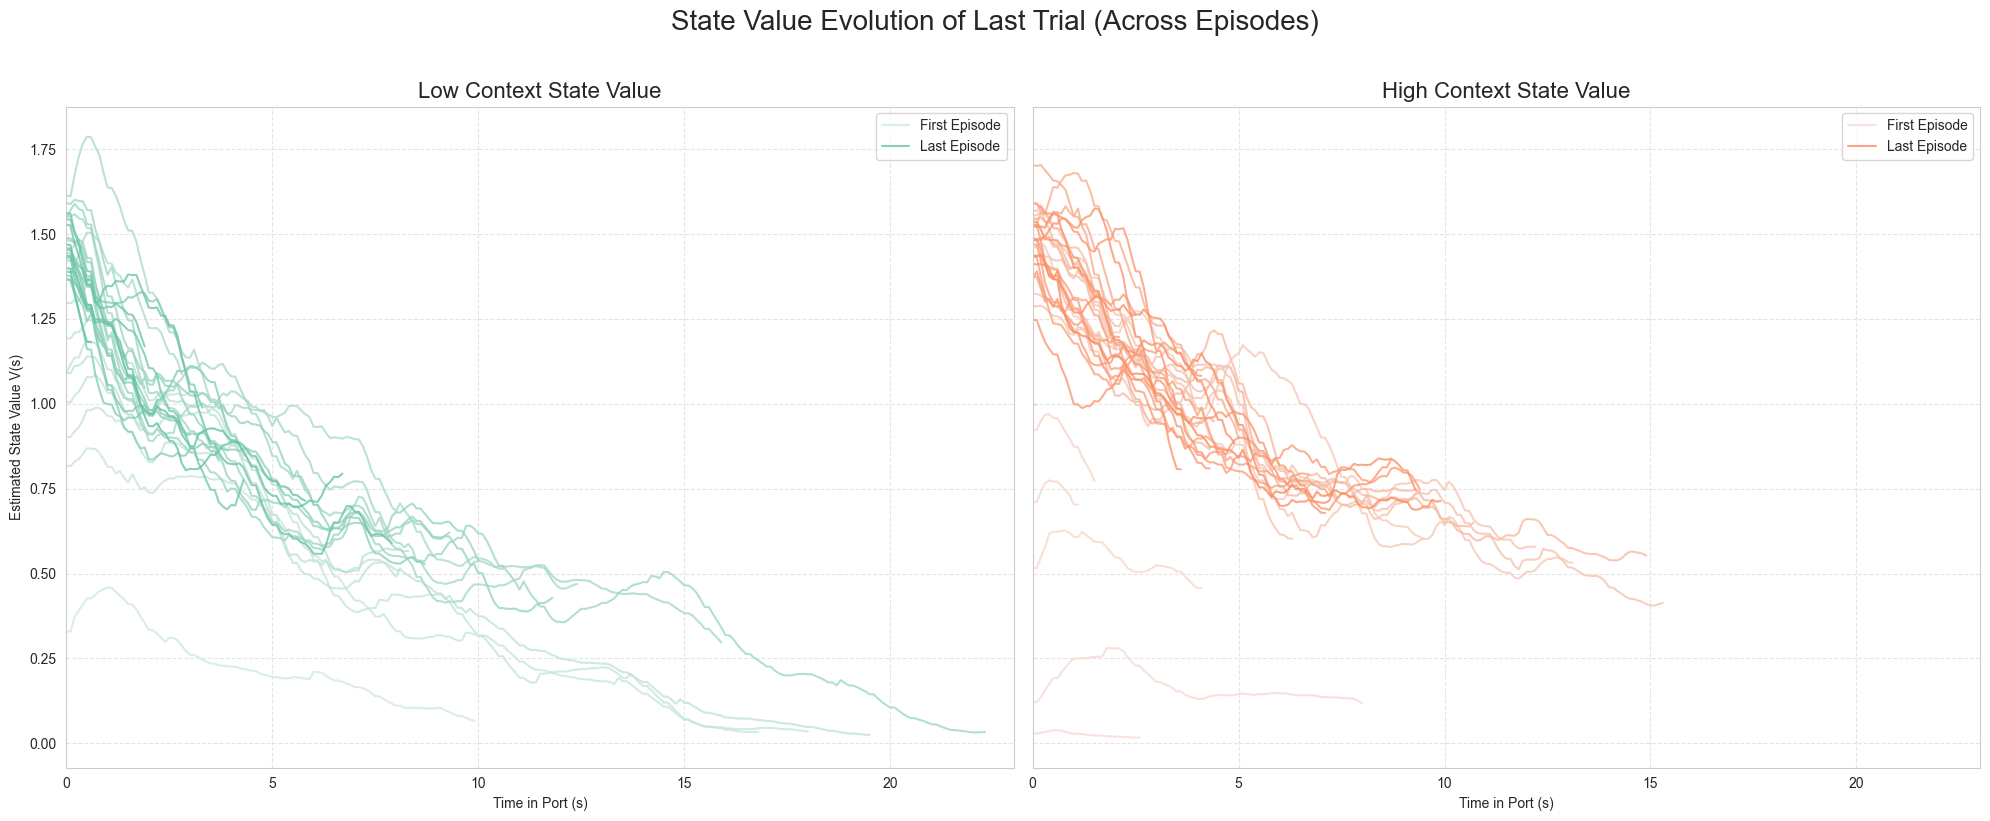

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

# --- Configuration ---
INPUT_FILE = "last_trial_value_evolution_by_episode.parquet"
OUTPUT_PLOT_FILE = "last_trial_evolution_by_context.png"

color_context_0 = sns.color_palette("Set2")[0]
color_context_1 = sns.color_palette("Set2")[1]
cmap_context_0 = sns.light_palette(color_context_0, as_cmap=True)
cmap_context_1 = sns.light_palette(color_context_1, as_cmap=True)

# --- 1. Load the Data ---
print(f"Loading data from {INPUT_FILE}...")
df = pd.read_parquet(INPUT_FILE)

if df is not None:
    # --- 2. "Explode" the Data ---
    print("Unpacking 'value_evolution' data...")
    expanded_data = []

    for _, row in df.iterrows():
        episode = row['episode_index']
        context = row['context']

        # 'value_evolution' is a list of step-dictionaries
        for step_data in row['value_evolution']:
            step_data['episode_index'] = episode
            step_data['context'] = context
            expanded_data.append(step_data)

    expanded_df = pd.DataFrame(expanded_data)

    if expanded_df.empty:
        print("Error: Expanded data is empty. Cannot plot.")
    else:
        print("Data unpacked successfully. Now plotting...")

        # --- 3. Filter Data by Context ---
        # '0.4' phase is context 0.0; '0.8' phase is context 1.0
        df_context_0 = expanded_df[expanded_df['context'] == 0.0]
        df_context_1 = expanded_df[expanded_df['context'] == 1.0]

        # --- 4. Create Subplots ---
        fig, (ax0, ax1) = plt.subplots(
            nrows=1,
            ncols=2,
            figsize=(20, 8),
            sharey=True
        )

        # --- 5. Plot for Context 0.0 ("0.4") ---
        ax0.set_title("Low Context State Value", fontsize=16)
        if not df_context_0.empty:
            # Get all episodes that have data for this context
            episodes_c0 = df_context_0['episode_index'].unique()
            episodes_c0.sort()
            first_episode_c0 = episodes_c0[0]
            last_episode_c0 = episodes_c0[-1]
            norm_c0 = mcolors.Normalize(vmin=episodes_c0.min(), vmax=episodes_c0.max())

            for episode in episodes_c0:
                episode_trial_df = df_context_0[df_context_0['episode_index'] == episode]
                norm_value = norm_c0(episode)
                remapped_value = 0.2 + (norm_value * 0.8)
                color = cmap_context_0(remapped_value)
                label = None

                if episode == first_episode_c0:
                    label = f"First Episode"
                elif episode == last_episode_c0:
                    label = f"Last Episode"

                ax0.plot(
                    episode_trial_df['time_in_port'],
                    episode_trial_df['state_value'],
                    color=color, # Use the remapped, more visible color
                    alpha=0.8,
                    linewidth=1.5,
                    label=label # Add the selective label
                )

            ax0.legend()

        ax0.set_xlabel("Time in Port (s)")
        ax0.set_ylabel("Estimated State Value V(s)")
        ax0.grid(True, linestyle='--', alpha=0.5)

        # --- 6. Plot for Context 1.0 ("0.8") ---
        ax1.set_title("High Context State Value", fontsize=16)
        if not df_context_1.empty:
            episodes_c1 = df_context_1['episode_index'].unique()
            episodes_c1.sort()
            first_episode_c1 = episodes_c1[0]
            last_episode_c1 = episodes_c1[-1]
            norm_c1 = mcolors.Normalize(vmin=episodes_c1.min(), vmax=episodes_c1.max())

            for episode in episodes_c1:
                episode_trial_df = df_context_1[df_context_1['episode_index'] == episode]
                norm_value = norm_c1(episode)
                remapped_value = 0.2 + (norm_value * 0.8)
                color = cmap_context_1(remapped_value)
                label = None
                if episode == first_episode_c1:
                    label = f"First Episode"
                elif episode == last_episode_c1:
                    label = f"Last Episode"

                ax1.plot(
                    episode_trial_df['time_in_port'],
                    episode_trial_df['state_value'],
                    color=color,
                    alpha=0.8,
                    linewidth=1.5,
                    label=label
                )

            ax1.legend()

        ax1.set_xlabel("Time in Port (s)")
        ax1.grid(True, linestyle='--', alpha=0.5)

        # --- 7. Finalize and Save ---
        ax0.set_xlim([0, 23])
        ax1.set_xlim([0, 23])
        fig.suptitle("State Value Evolution of Last Trial (Across Episodes)", fontsize=20, y=1.02)
        fig.tight_layout()
        #
        # print(f"Saving plot to {OUTPUT_PLOT_FILE}...")
        # plt.savefig(OUTPUT_PLOT_FILE, dpi=300, bbox_inches='tight')
        # plt.close(fig)
        print("Plotting complete.")

#### Plot weight evolution to see if the weights converge

Loading data from last_trial_value_evolution_by_episode.parquet...
Data loaded. Creating plot...
Plotting complete.


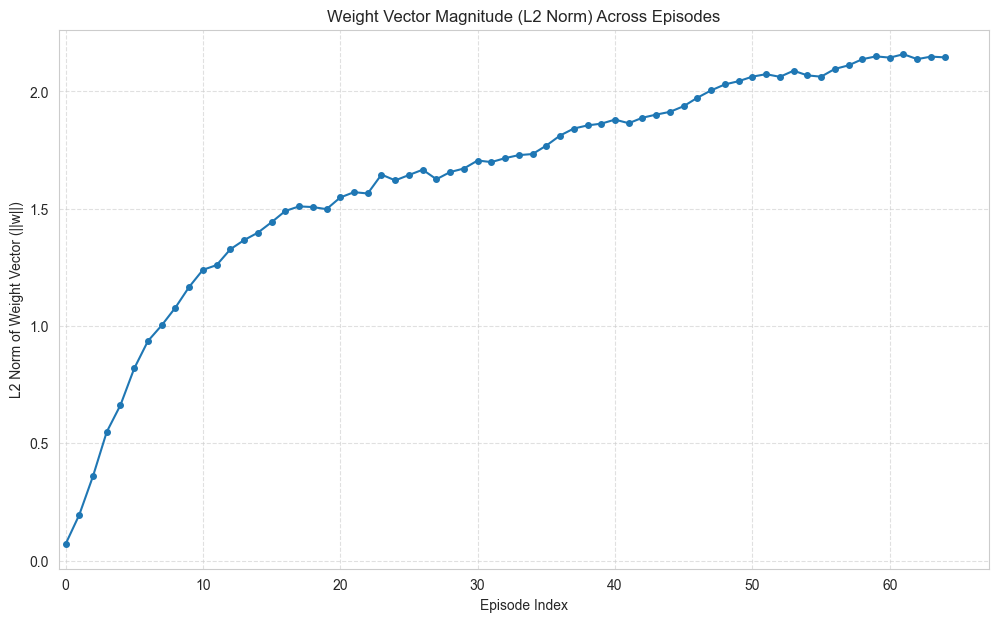

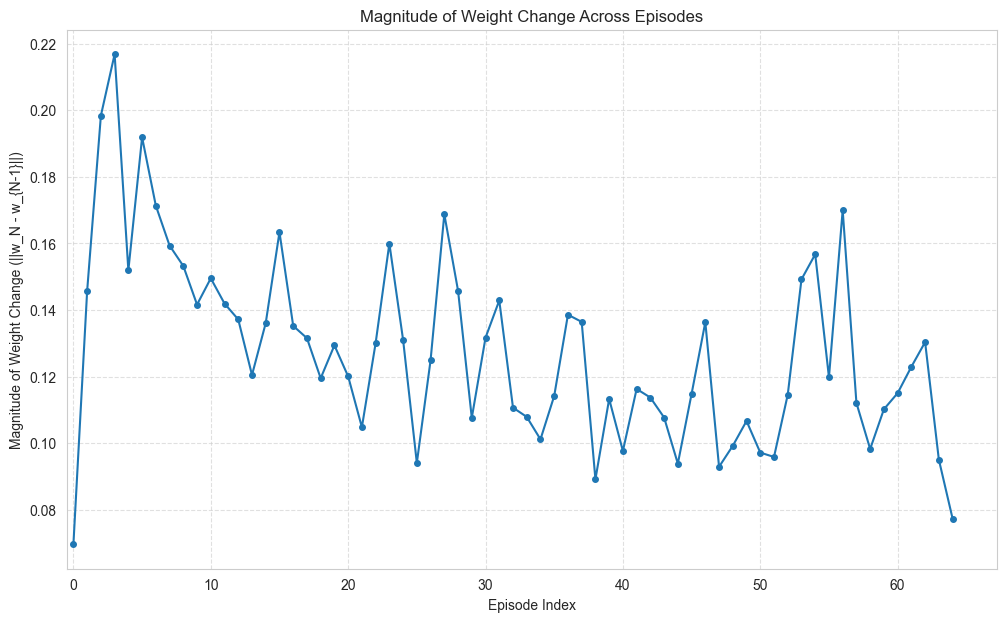

In [120]:
import pandas as pd
import matplotlib.pyplot as plt

INPUT_FILE = "last_trial_value_evolution_by_episode.parquet"
print(f"Loading data from {INPUT_FILE}...")
df = pd.read_parquet(INPUT_FILE)
print("Data loaded. Creating plot...")

fig, ax = plt.subplots(figsize=(12, 7))
df = df.sort_values(by='episode_index')

# Plot episode on the x-axis and the L2 norm on the y-axis
ax.plot(
    df['episode_index'],
    df['weight_norm_l2'],
    marker='o',
    markersize=4,
    linestyle='-',
    linewidth=1.5
)

ax.set_xlabel("Episode Index")
ax.set_ylabel("L2 Norm of Weight Vector (||w||)")
ax.set_title("Weight Vector Magnitude (L2 Norm) Across Episodes")
ax.grid(True, linestyle='--', alpha=0.6)

ax.set_xlim(left=-0.5)

# print(f"Saving plot to {OUTPUT_PLOT_FILE}...")
# plt.savefig(OUTPUT_PLOT_FILE, dpi=300, bbox_inches='tight')
# plt.close(fig)

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(
    df['episode_index'],
    df['weight_diff_norm_l2'],
    marker='o',
    markersize=4,
    linestyle='-',
    linewidth=1.5
)

ax.set_xlabel("Episode Index")
ax.set_ylabel("Magnitude of Weight Change (||w_N - w_{N-1}||)")
ax.set_title("Magnitude of Weight Change Across Episodes")
ax.grid(True, linestyle='--', alpha=0.6)

ax.set_xlim(left=-0.5)

# print(f"Saving plot to {OUTPUT_PLOT_FILE}...")
# plt.savefig(OUTPUT_PLOT_FILE, dpi=300, bbox_inches='tight')
# plt.close(fig)
print("Plotting complete.")

#### Plot the learned values for the context port and the gambling port under different contexts

In [121]:
import pandas as pd

print("Calculating learned values for all probe states...")

# 1. Create a dictionary to store the final learned values
final_probe_values = {}

# 2. Iterate through the probe_states_dict you defined earlier
for state_name, state_vector in probe_states_dict.items():
    # 3. Get the learned value from the agent for each state
    value = agent.get_value(state_vector)
    final_probe_values[state_name] = value

print("Calculation complete.")

# 4. Print a few examples to check
print("\n--- Example Learned Values ---")
example_keys = list(final_probe_values.keys())[::100] # Show some samples
for k in example_keys:
    print(f"{k}: {final_probe_values[k]:.4f}")

# 5. Convert to a DataFrame for plotting and analysis
print("\nConverting to DataFrame for analysis...")
value_list = []
for state_name, value in final_probe_values.items():
    # Parse the state_name to get sortable columns for plotting
    port_str = "Gambling" if "Gamb" in state_name else "Context"
    context_str = "High" if "High" in state_name else "Low"
    time_str = state_name.split("=")[-1].replace("s", "").replace(")", "")

    value_list.append({
        "state_name": state_name,
        "port": port_str,
        "context": context_str,
        "time_in_port": float(time_str),
        "learned_value": value
    })

final_value_df = pd.DataFrame(value_list)

print("DataFrame created. You can now plot V(s) vs. time_in_port.")
print(final_value_df.head())

Calculating learned values for all probe states...
Calculation complete.

--- Example Learned Values ---
V(Gamb_Low_tip=0.0s): 1.3025
V(Gamb_Low_tip=5.0s): 0.6771
V(Gamb_Low_tip=10.0s): 0.6477
V(Gamb_Low_tip=15.0s): 0.5185
V(Gamb_Low_tip=20.0s): 0.1346
V(Cont_Low_tip=0.0s): 0.6872
V(Cont_Low_tip=5.0s): 0.6001
V(Cont_Low_tip=10.0s): 0.1576

Converting to DataFrame for analysis...
DataFrame created. You can now plot V(s) vs. time_in_port.
              state_name      port context  time_in_port  learned_value
0   V(Gamb_Low_tip=0.0s)  Gambling     Low           0.0       1.302469
1  V(Gamb_High_tip=0.0s)  Gambling    High           0.0       1.462805
2   V(Gamb_Low_tip=0.1s)  Gambling     Low           0.1       1.302469
3  V(Gamb_High_tip=0.1s)  Gambling    High           0.1       1.462805
4   V(Gamb_Low_tip=0.2s)  Gambling     Low           0.2       1.227329


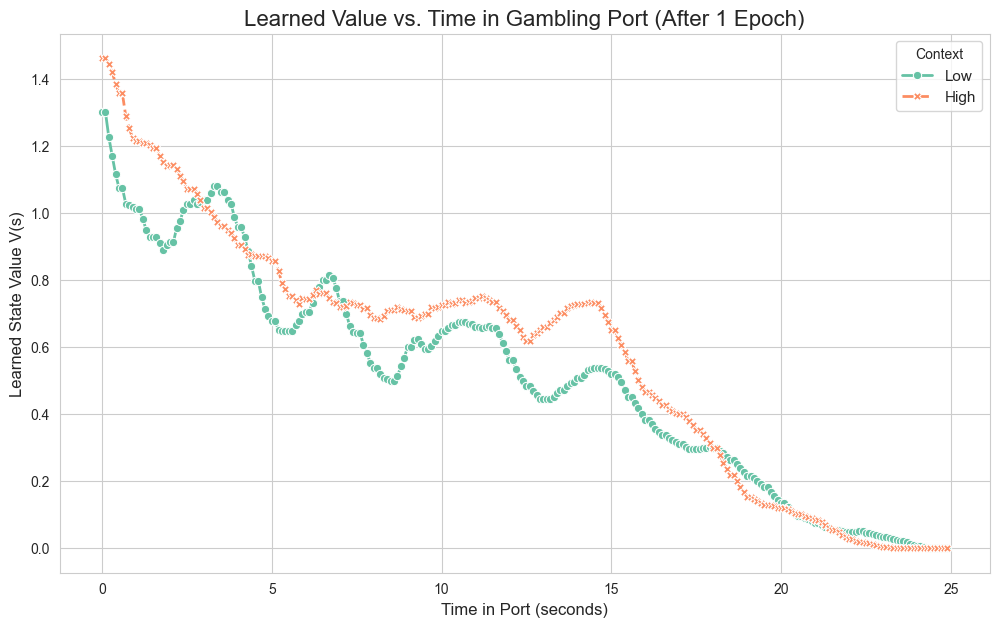

In [122]:
# plot
gambling_data = final_value_df[final_value_df['port'] == 'Gambling']
custom_palette = {
    'Low': sns.color_palette('Set2')[0],
    'High': sns.color_palette('Set2')[1]
}
plt.figure(figsize=(12, 7))
ax1 = sns.lineplot(
    data=gambling_data,
    x='time_in_port',
    y='learned_value',
    hue='context',
    style='context',
    palette=custom_palette,
    markers=True,
    lw=2
)
ax1.set_title('Learned Value vs. Time in Gambling Port (After 1 Epoch)', fontsize=16)
ax1.set_xlabel('Time in Port (seconds)', fontsize=12)
ax1.set_ylabel('Learned State Value V(s)', fontsize=12)
ax1.legend(title='Context', fontsize=11)

# Save the figure
# gambling_plot_filename = 'gambling_port_learned_value.png'
# plt.savefig(gambling_plot_filename)
# print(f"Successfully saved Gambling Port plot to {gambling_plot_filename}")
plt.show() # Display the plot in the notebook

Successfully saved Context Port plot to context_port_learned_value_custom_color.png


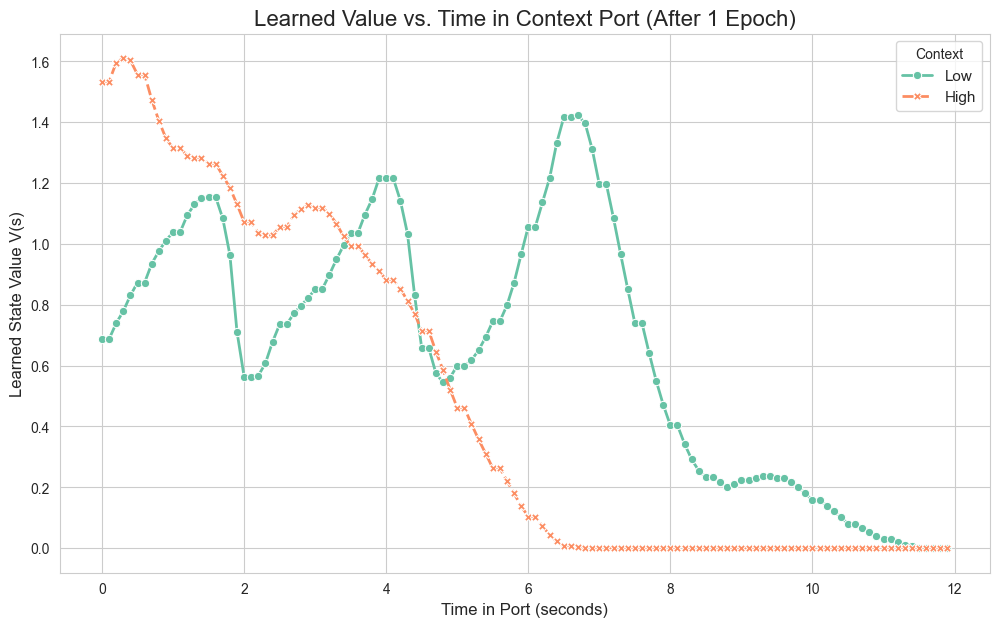

In [123]:
# plot context port
context_data = final_value_df[final_value_df['port'] == 'Context']

plt.figure(figsize=(12, 7))
ax2 = sns.lineplot(
    data=context_data,
    x='time_in_port',
    y='learned_value',
    hue='context',
    style='context',
    palette=custom_palette, # <-- YOUR CUSTOM COLORS ARE HERE
    markers=True,
    lw=2
)
ax2.set_title('Learned Value vs. Time in Context Port (After 1 Epoch)', fontsize=16)
ax2.set_xlabel('Time in Port (seconds)', fontsize=12)
ax2.set_ylabel('Learned State Value V(s)', fontsize=12)
ax2.legend(title='Context', fontsize=11)

# Save the figure
context_plot_filename = 'context_port_learned_value_custom_color.png'
plt.savefig(context_plot_filename)
print(f"Successfully saved Context Port plot to {context_plot_filename}")
plt.show() # Display the plot in the notebook

### Iterative training that run all the episodes for multiple times

In [150]:
# Configuration
ANIMAL_ID = "SZ037"
POOLED_DATA_FILE = f"pooled_transitions_{ANIMAL_ID}.pkl"
USE_REDUNDANT_FEATURES = False

In [151]:
# Load transitions first
import pickle
from mouse_playback_environment import MousePlaybackEnvironment  # NEW
from mouse_playback_agent import MousePlaybackAgent

print(f"Loading pooled transitions from {POOLED_DATA_FILE}...")
try:
    with open(POOLED_DATA_FILE, 'rb') as f:
        pooled_transitions = pickle.load(f)
    print(f"Loaded {len(pooled_transitions)} transitions.")
except FileNotFoundError:
    print(f"Error: {POOLED_DATA_FILE} not found.")
    pooled_transitions = None
except Exception as e:
    print(f"An error occurred loading the pickle file: {e}")
    pooled_transitions = None

# Set up the environment and the agent
# Define the full 6-feature configurations
full_scales = [
    -1,  # 0: port
    1 / 2.0,  # 1: time_in_port
    1 / 1.0,  # 2: event_timer
    -1,  # 3: context
    -1,  # 4: rewards_in_context
    -1  # 5: gambling_disabled
]

# Create the final config
if USE_REDUNDANT_FEATURES:
    scales_to_use = full_scales
    print("Agent will use 6 features (including event_timer).")
else:
    # To "remove" a feature, we set its scale to 0.0
    # and its tiling dimension to 1 (so it's not subdivided).
    scales_to_use = [
        -1,  # 0: port
        1 / 2.0,  # 1: time_in_port
        0.0,  # 2: event_timer (SCALE SET TO 0)
        -1,  # 3: context
        0.0,  # 4: rewards_in_context
        -1  # 5: gambling_disabled
    ]
    print("Agent will use 4 features (event_timer and context_rewards scales are 0).")

if pooled_transitions:
    print("Initializing agent and environment...")

    env = MousePlaybackEnvironment()
    env_params_for_playback = {"transitions": pooled_transitions, "time_step_duration": 0.1}
    env.env_init(env_params_for_playback)

    agent = MousePlaybackAgent()
    agent_params = {
        "discount": 0.95,  # Or chosen value
        "step_size": 0.1,  # Start with a smaller step size for stability over large datasets
        "num_tilings": 16,
        "iht_size": 4096,
        "gambling_max_time_s": 30.0,  # Match data_loader params if used
        "context_rewards_max": 4,  # Match data_loader params if used
        "scales": scales_to_use
    }  # agent parameters
    agent.agent_init(agent_params)


Loading pooled transitions from pooled_transitions_SZ037.pkl...
Loaded 700965 transitions.
Agent will use 4 features (event_timer and context_rewards scales are 0).
Initializing agent and environment...
Playback environment initialized with 700965 transitions.


In [152]:
# Iterative training
import numpy as np
from tqdm import tqdm # for progress bar

max_epochs = 50 # Adjust as needed
convergence_threshold = 0.02 # Adjust as needed
last_w = agent.w.copy()
weight_change_across_epochs = []

num_total_steps = len(pooled_transitions) # Total transitions in the pooled list

for epoch in range(max_epochs):
    print(f"Starting Epoch {epoch+1}/{max_epochs}")

    # --- Start the very first episode of the epoch ---
    current_observation = env.env_start() # Resets env index to 0
    agent.agent_start(current_observation)

    # for step_idx in tqdm(range(num_total_steps)):
    for step_idx in range(num_total_steps):
        # Action is ignored by the playback environment
        reward, next_observation, terminal = env.env_step(action=None)

        if terminal:
            agent.agent_end(reward)
            # Check if this is the end of the entire pooled list
            if env.current_step_index < num_total_steps:
                 # --- Start the next episode within the epoch ---
                 # The environment has already advanced its index, so next_observation
                 # is the start state of the next session in the pool.
                 current_observation = next_observation
                 agent.agent_start(current_observation)
            else:
                 # This was the very last transition in the pool
                 break # End the epoch
        else:
            # Standard step within an episode
            agent.agent_step(reward, next_observation)
            current_observation = next_observation # Update for the next iteration if not terminal

    # --- Check for convergence after each epoch ---
    w_change = np.sqrt(np.sum((agent.w - last_w)**2))
    weight_change_across_epochs.append(w_change)
    print(f"Epoch {epoch+1} finished. Weight change (L2 norm): {w_change:.8f}")
    if w_change < convergence_threshold and epoch > 0:
        print("Convergence detected.")
        break
    last_w = agent.w.copy()
    # Reset environment index for the next epoch pass (handled by env.env_start() at loop top)

# --- Save the converged weights ---
converged_weights = agent.w.copy()
np.save(f"expert_weights_{ANIMAL_ID}_multi_epoch.npy", converged_weights)
print("Saved converged expert weights.")

Starting Epoch 1/50
Epoch 1 finished. Weight change (L2 norm): 2.62563410
Starting Epoch 2/50
Epoch 2 finished. Weight change (L2 norm): 0.54311646
Starting Epoch 3/50
Epoch 3 finished. Weight change (L2 norm): 0.29671359
Starting Epoch 4/50
Epoch 4 finished. Weight change (L2 norm): 0.20435292
Starting Epoch 5/50
Epoch 5 finished. Weight change (L2 norm): 0.15651627
Starting Epoch 6/50
Epoch 6 finished. Weight change (L2 norm): 0.12746664
Starting Epoch 7/50
Epoch 7 finished. Weight change (L2 norm): 0.10804444
Starting Epoch 8/50
Epoch 8 finished. Weight change (L2 norm): 0.09417214
Starting Epoch 9/50
Epoch 9 finished. Weight change (L2 norm): 0.08371019
Starting Epoch 10/50
Epoch 10 finished. Weight change (L2 norm): 0.07549770
Starting Epoch 11/50
Epoch 11 finished. Weight change (L2 norm): 0.06886112
Starting Epoch 12/50
Epoch 12 finished. Weight change (L2 norm): 0.06338462
Starting Epoch 13/50
Epoch 13 finished. Weight change (L2 norm): 0.05879399
Starting Epoch 14/50
Epoch 14 

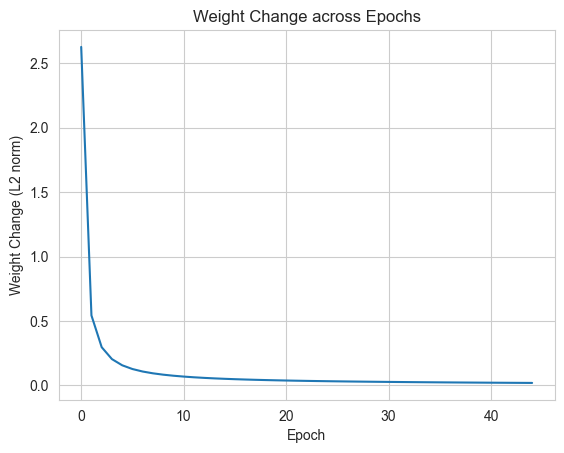

In [153]:
# plot weight changes
fig, ax = plt.subplots()
ax.plot(weight_change_across_epochs)
ax.set_xlabel("Epoch")
ax.set_ylabel("Weight Change (L2 norm)")
ax.set_title("Weight Change across Epochs")
plt.show()

In [154]:
# prepare data for plotting of learned values
import pandas as pd

print("Calculating learned values for all probe states...")

# 1. Create a dictionary to store the final learned values
final_probe_values = {}

# 2. Iterate through the probe_states_dict you defined earlier
for state_name, state_vector in probe_states_dict.items():
    # 3. Get the learned value from the agent for each state
    value = agent.get_value(state_vector)
    final_probe_values[state_name] = value

print("Calculation complete.")

# 4. Print a few examples to check
print("\n--- Example Learned Values ---")
example_keys = list(final_probe_values.keys())[::100] # Show some samples
for k in example_keys:
    print(f"{k}: {final_probe_values[k]:.4f}")

# 5. Convert to a DataFrame for plotting and analysis
print("\nConverting to DataFrame for analysis...")
value_list = []
for state_name, value in final_probe_values.items():
    # Parse the state_name to get sortable columns for plotting
    port_str = "Gambling" if "Gamb" in state_name else "Context"
    context_str = "High" if "High" in state_name else "Low"
    time_str = state_name.split("=")[-1].replace("s", "").replace(")", "")

    value_list.append({
        "state_name": state_name,
        "port": port_str,
        "context": context_str,
        "time_in_port": float(time_str),
        "learned_value": value
    })

final_value_df = pd.DataFrame(value_list)

Calculating learned values for all probe states...
Calculation complete.

--- Example Learned Values ---
V(Gamb_Low_tip=0.0s): 1.1604
V(Gamb_Low_tip=5.0s): 0.5454
V(Gamb_Low_tip=10.0s): 0.6844
V(Gamb_Low_tip=15.0s): 0.6227
V(Gamb_Low_tip=20.0s): 0.5113
V(Cont_Low_tip=0.0s): 0.7439
V(Cont_Low_tip=5.0s): 0.8581
V(Cont_Low_tip=10.0s): 1.2312

Converting to DataFrame for analysis...


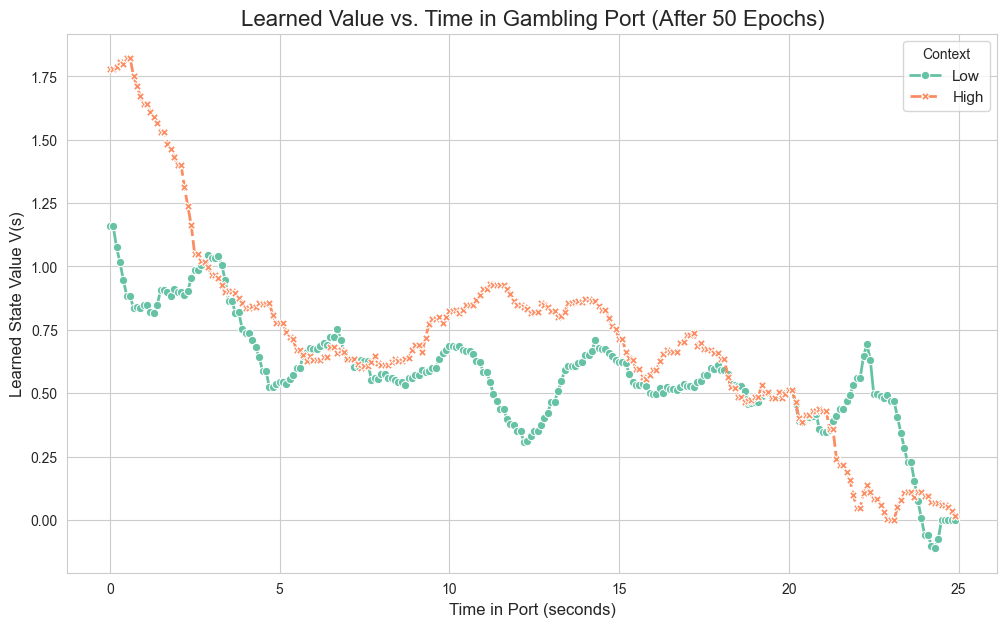

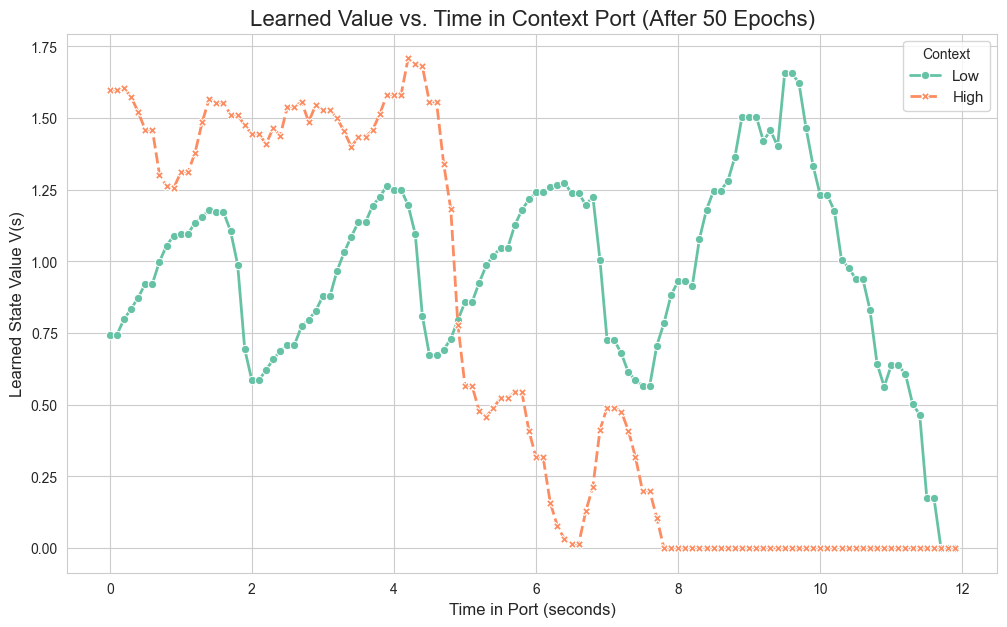

In [155]:
# Plot learned values in both ports
gambling_data = final_value_df[final_value_df['port'] == 'Gambling']
custom_palette = {
    'Low': sns.color_palette('Set2')[0],
    'High': sns.color_palette('Set2')[1]
}
plt.figure(figsize=(12, 7))
ax1 = sns.lineplot(
    data=gambling_data,
    x='time_in_port',
    y='learned_value',
    hue='context',
    style='context',
    palette=custom_palette,
    markers=True,
    lw=2
)
ax1.set_title(f'Learned Value vs. Time in Gambling Port (After {max_epochs} Epochs)', fontsize=16)
ax1.set_xlabel('Time in Port (seconds)', fontsize=12)
ax1.set_ylabel('Learned State Value V(s)', fontsize=12)
ax1.legend(title='Context', fontsize=11)

# Save the figure
# gambling_plot_filename = 'gambling_port_learned_value.png'
# plt.savefig(gambling_plot_filename)
# print(f"Successfully saved Gambling Port plot to {gambling_plot_filename}")
plt.show() # Display the plot in the notebook

# ------------------------------------------------------------
context_data = final_value_df[final_value_df['port'] == 'Context']

plt.figure(figsize=(12, 7))
ax2 = sns.lineplot(
    data=context_data,
    x='time_in_port',
    y='learned_value',
    hue='context',
    style='context',
    palette=custom_palette, # <-- YOUR CUSTOM COLORS ARE HERE
    markers=True,
    lw=2
)
ax2.set_title(f'Learned Value vs. Time in Context Port (After {max_epochs} Epochs)', fontsize=16)
ax2.set_xlabel('Time in Port (seconds)', fontsize=12)
ax2.set_ylabel('Learned State Value V(s)', fontsize=12)
ax2.legend(title='Context', fontsize=11)

# Save the figure
# context_plot_filename = 'context_port_learned_value_custom_color.png'
# plt.savefig(context_plot_filename)
# print(f"Successfully saved Context Port plot to {context_plot_filename}")
plt.show() # Display the plot in the notebook

## 2. Analyze TD Errors and TD Values of Target Dataset

In [142]:
import numpy as np
expert_weights = np.load(f"expert_weights_{ANIMAL_ID}_multi_epoch.npy")

In [143]:
target_animal_id = ANIMAL_ID # Example
target_session_id = 5

target_df = load_behavior_data(target_animal_id, session_id=target_session_id)

if target_df is not None:
    env_params = {
    "time_step_duration": 0.1,
    "session_duration_min": 18,
    "context_rewards_max": 4,
    "block_duration_min": 3
    }
    target_transitions = convert_behavior_data_to_state_transitions(target_df, env_params)
    print(f"Loaded {len(target_transitions)} transitions for target session.")
else:
    raise ValueError("Failed to load target session data.")

Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ037\processed_data\SZ037_2023-12-19T13_16_pi_events_processed.parquet
session: SZ037_2023-12-19T13_16
Test new conversion function 5th go...
Processing time steps...
Processed 10799 time steps.
Loaded 10799 transitions for target session.


In [144]:
# Define agent parameters (should match pre-training parameters ideally)
if USE_REDUNDANT_FEATURES:
    scales_to_use = full_scales
    print("Agent will use 6 features (including event_timer).")
else:
    # To "remove" a feature, we set its scale to 0.0
    # and its tiling dimension to 1 (so it's not subdivided).
    scales_to_use = [
        -1,  # 0: port
        1 / 2.0, # 1: time_in_port
        0.0,      # 2: event_timer (SCALE SET TO 0)
        -1,  # 3: context
        0.0,  # 4: rewards_in_context
        -1   # 5: gambling_disabled
    ]
    print("Agent will use 4 features (event_timer and context_rewards scales are 0).")

agent_params = {
    "discount": 0.95,
    "step_size": 0.0, # IMPORTANT: Set step_size to 0 for analysis-only run if desired
                       # Alternatively, keep it small and just extract TD errors before update
    "num_tilings": 16,
    "iht_size": 4096,
    "gambling_max_time_s": 30.0,
    "context_rewards_max": 4,
    "scales": scales_to_use
}

analysis_agent = MousePlaybackAgent()
analysis_agent.agent_init(agent_params)

# *** Set the weights as expert weights ***
if expert_weights.shape == analysis_agent.w.shape:
    analysis_agent.w = expert_weights.copy() # Use copy to avoid potential issues
    print("Agent weights initialized with pre-trained expert weights.")
else:
    raise ValueError(f"Loaded weights shape {expert_weights.shape} does not match agent weight shape {analysis_agent.w.shape}")

Agent will use 4 features (event_timer and context_rewards scales are 0).
Agent weights initialized with pre-trained expert weights.


In [145]:
# Initialize environment
analysis_env = MousePlaybackEnvironment()
env_params_for_playback = {"transitions": target_transitions, "time_step_duration": 0.1}
analysis_env.env_init(env_params_for_playback)

Playback environment initialized with 10799 transitions.


### 2.1 TD errors

In [146]:
target_td_errors = [] # List to store TD errors

current_observation = analysis_env.env_start()
analysis_agent.agent_start(current_observation)

num_target_steps = len(target_transitions)

for step_idx in range(num_target_steps):
    reward, next_observation, terminal = analysis_env.env_step(action=None) # Action is ignored in Playback_environment

    # --- Calculate TD error ---
    v_next = analysis_agent.get_value(next_observation) if not terminal else 0.0
    v_current = analysis_agent.get_value(current_observation) # Value before potential update
    td_error = reward + analysis_agent.discount * v_next - v_current
    target_td_errors.append(td_error)
    # --------------------------------------------------------------------------

    if terminal:
        analysis_agent.agent_end(reward) # Agent updates internal state (even w/ alpha=0)
        break
    else:
        analysis_agent.agent_step(reward, next_observation) # Agent updates internal state (like last_state_tiles)
        current_observation = next_observation

print(f"Collected {len(target_td_errors)} TD errors for the target session.")

# Convert to NumPy array for easier analysis
target_td_errors_np = np.array(target_td_errors)

Collected 10799 TD errors for the target session.


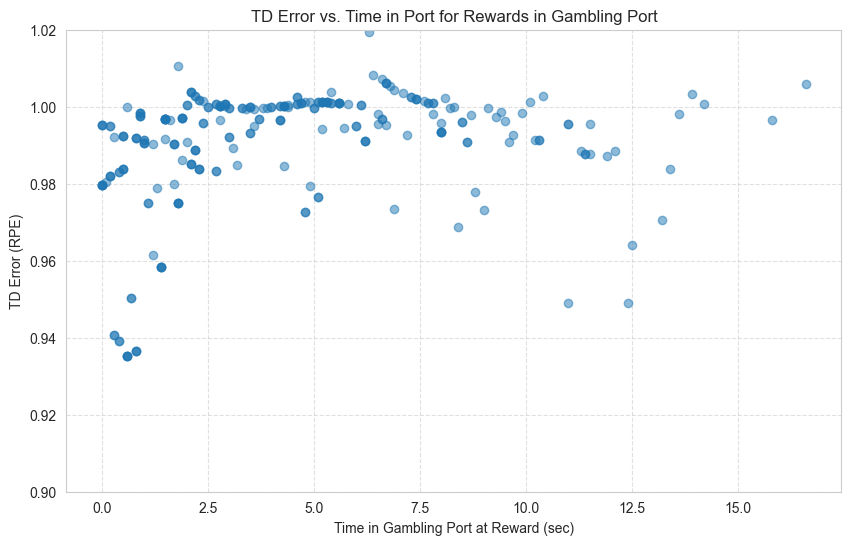

In [148]:
# Find the TD-errors corresponding to rewards delivered in the gambling port
import matplotlib.pyplot as plt

gambling_port_id = 1.0 # ID for the gambling port
rewarded_gambling_steps_time = []
rewarded_gambling_steps_td_error = []

# Iterate through the transitions and corresponding TD errors
for i in range(len(target_transitions)):
    obs_t, _, reward_t_plus_1, _, _ = target_transitions[i]
    td_error = target_td_errors_np[i]

    # Check if reward was given AND the port was the gambling port
    if reward_t_plus_1 > 0 and obs_t[0] == gambling_port_id:
        time_in_port = obs_t[1]
        rewarded_gambling_steps_time.append(time_in_port)
        rewarded_gambling_steps_td_error.append(td_error)

# --- Plotting ---
if not rewarded_gambling_steps_time:
    print("No rewarded steps found in the gambling port for this session.")
else:
    plt.figure(figsize=(10, 6))
    plt.scatter(rewarded_gambling_steps_time, rewarded_gambling_steps_td_error, alpha=0.5)
    plt.xlabel("Time in Gambling Port at Reward (sec)")
    plt.ylabel("TD Error (RPE)")
    plt.ylim([0.90, 1.02])
    plt.title("TD Error vs. Time in Port for Rewards in Gambling Port")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

## Visualize different compartments of TD-error calculation

### (1) Values and Errors, Separated

Extracting TD error components for rewarded gambling steps...
Found 286 rewarded steps in enabled gambling port.


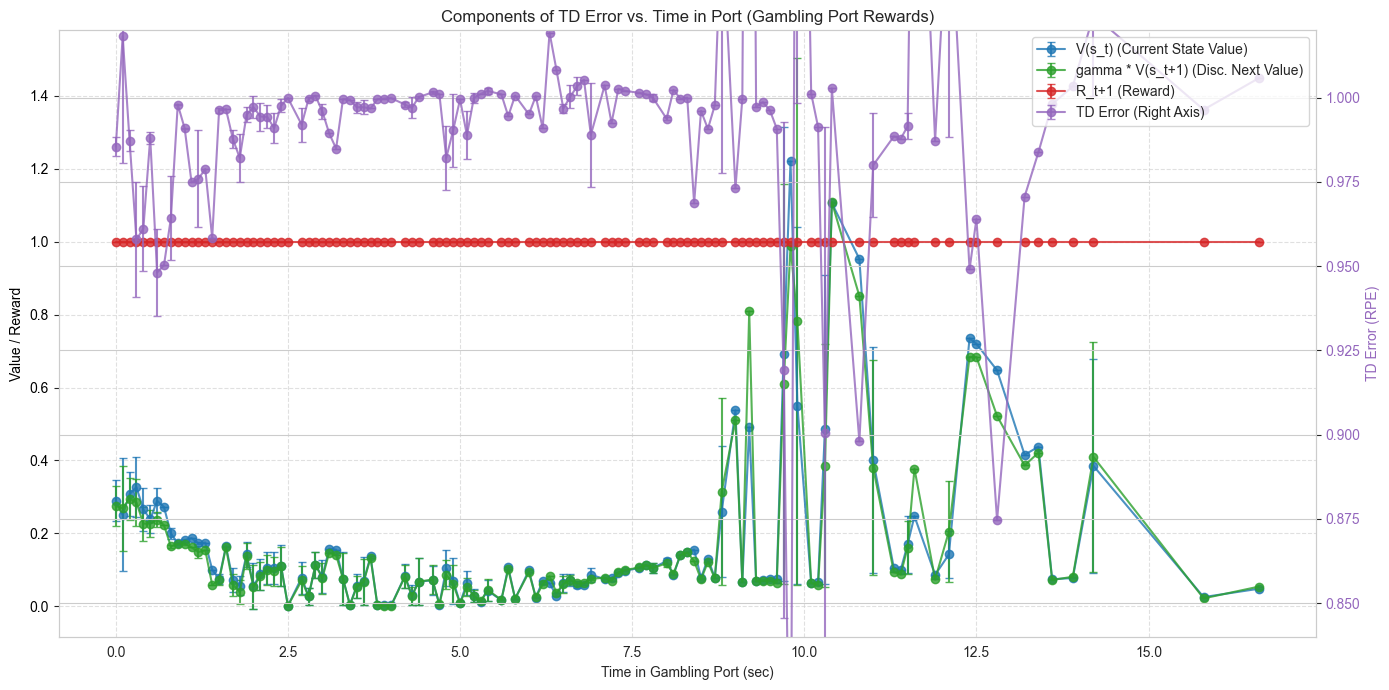

In [149]:
# --- Parameters ---
gambling_port_id = 1.0
gambling_enabled_flag = 0.0
gamma = analysis_agent.discount # Use the agent's discount factor

# --- Extract Components for Rewarded Gambling Steps ---
plot_data_components = []

print("Extracting TD error components for rewarded gambling steps...")
for i in range(len(target_transitions)):
    obs_t, _, reward_t_plus_1, next_obs_t_plus_1, terminal_flag = target_transitions[i]
    td_error = target_td_errors_np[i]

    # Check conditions: reward > 0 AND in gambling port AND gambling enabled
    if reward_t_plus_1 > 0 and obs_t[0] == gambling_port_id and obs_t[5] == gambling_enabled_flag:
        time_in_port = obs_t[1]

        # Calculate V(s_t) - value of the state where reward was triggered
        v_current = analysis_agent.get_value(obs_t)

        # Calculate gamma * V(s_t+1)
        v_next = analysis_agent.get_value(next_obs_t_plus_1) if not terminal_flag else 0.0
        discounted_v_next = gamma * v_next

        plot_data_components.append({
            'time_in_port': time_in_port,
            'reward': reward_t_plus_1,
            'v_current': v_current,
            'discounted_v_next': discounted_v_next,
            'td_error': td_error,
            'context': int(obs_t[3]) # Keep context if needed for later filtering
        })

print(f"Found {len(plot_data_components)} rewarded steps in enabled gambling port.")

# --- Prepare DataFrame and Calculate Averages ---
if not plot_data_components:
    print("No relevant data points found to plot.")
else:
    df_components = pd.DataFrame(plot_data_components)

    # Group by time_in_port and calculate mean and SEM for each component
    avg_components = df_components.groupby('time_in_port').agg(
        reward_mean=('reward', 'mean'),
        reward_sem=('reward', 'sem'),
        v_current_mean=('v_current', 'mean'),
        v_current_sem=('v_current', 'sem'),
        disc_v_next_mean=('discounted_v_next', 'mean'),
        disc_v_next_sem=('discounted_v_next', 'sem'),
        td_error_mean=('td_error', 'mean'),
        td_error_sem=('td_error', 'sem')
    ).reset_index()

    # Fill NaN SEM values (occur for groups of size 1) with 0 for plotting
    avg_components = avg_components.fillna(0)

    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot components sharing the left axis
    color_v_curr = 'tab:blue'
    color_v_next = 'tab:green'
    color_reward = 'tab:red'
    ax1.set_xlabel('Time in Gambling Port (sec)')
    ax1.set_ylabel('Value / Reward', color='black')
    ax1.errorbar(avg_components['time_in_port'], avg_components['v_current_mean'],
                 yerr=avg_components['v_current_sem'], label='V(s_t) (Current State Value)',
                 fmt='-o', capsize=3, alpha=0.8, color=color_v_curr)
    ax1.errorbar(avg_components['time_in_port'], avg_components['disc_v_next_mean'],
                 yerr=avg_components['disc_v_next_sem'], label='gamma * V(s_t+1) (Disc. Next Value)',
                 fmt='-o', capsize=3, alpha=0.8, color=color_v_next)
    ax1.errorbar(avg_components['time_in_port'], avg_components['reward_mean'],
                 yerr=avg_components['reward_sem'], label='R_t+1 (Reward)',
                 fmt='-o', capsize=3, alpha=0.8, color=color_reward)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Create a second y-axis for the TD error
    ax2 = ax1.twinx()
    color_td = 'tab:purple'
    ax2.set_ylabel('TD Error (RPE)', color=color_td)
    ax2.errorbar(avg_components['time_in_port'], avg_components['td_error_mean'],
                 yerr=avg_components['td_error_sem'], label='TD Error (Right Axis)',
                 fmt='-o', capsize=3, alpha=0.8, color=color_td)
    ax2.tick_params(axis='y', labelcolor=color_td)
    ax2.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Add a zero line for TD error
    ax2.set_ylim([0.84, 1.02])

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title('Components of TD Error vs. Time in Port (Gambling Port Rewards)')
    fig.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()